SCRIVI PRESENTAZIONE PROGETTO

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy.fft import fft, ifft, fftshift, ifftshift
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats,signal
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf



# Section 1 -Loading and dataset manipulation-

## Market Temperature

The market temperature dataset provides information on the barganing power between supply and demand in the housing market. An high market temperature value means favourable conditions for sellers, while low market temperatures suggests greater barganing power for buyers.

The market temperature index is provided on a weekly basis for each region (also defined as msa - metropolitan statistical areas- ) of the different US states.



**Market Temperature Dataset**

| **Attribute**                  | **Value**              |
| ------------------------------ | ---------------------- |
| **Time window**                | Jan 2018 - Oct 2024    |
| **Time Granularity**           | Monthly (end of the month) |
| **Number of Regions**          | 928                    |
| **Number of States**           | 51                     |
| **Number of observations**     | 77,024                 |
| **Number of missing values**   | 2,220                  |



### Loading market temperature dataset

In [2]:
market_temp=pd.read_csv("Market_temp_index_uc_month.csv")
market_temp

,RegionID,SizeRank,RegionName,RegionType,StateName,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,...,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30
0,102001,0,United States,country,NaN,50.0,50.0,52.0,54.0,55.0,...,63.0,63.0,62.0,59.0,57.0,55.0,53.0,52.0,51.0,50.0
1,394913,1,"New York, NY",msa,NY,53.0,52.0,55.0,57.0,56.0,...,92.0,90.0,87.0,81.0,78.0,77.0,77.0,74.0,71.0,71.0
2,753899,2,"Los Angeles, CA",msa,CA,69.0,66.0,66.0,67.0,66.0,...,85.0,83.0,80.0,74.0,71.0,67.0,65.0,63.0,62.0,63.0
3,394463,3,"Chicago, IL",msa,IL,48.0,49.0,51.0,52.0,51.0,...,74.0,76.0,75.0,71.0,67.0,64.0,61.0,58.0,56.0,56.0
4,394514,4,"Dallas, TX",msa,TX,55.0,55.0,58.0,60.0,59.0,...,67.0,67.0,64.0,59.0,55.0,52.0,49.0,48.0,49.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923,753929,935,"Zapata, TX",msa,TX,NaN,NaN,NaN,NaN,NaN,...,39.0,36.0,27.0,40.0,53.0,47.0,31.0,34.0,42.0,41.0
924,394743,936,"Ketchikan, AK",msa,AK,37.0,35.0,34.0,37.0,49.0,...,74.0,69.0,49.0,53.0,61.0,66.0,57.0,53.0,44.0,50.0
925,753874,937,"Craig, CO",msa,CO,3.0,23.0,52.0,67.0,56.0,...,61.0,55.0,59.0,57.0,48.0,33.0,21.0,28.0,41.0,37.0
926,395188,938,"Vernon, TX",msa,TX,51.0,45.0,NaN,48.0,65.0,...,83.0,78.0,64.0,65.0,61.0,52.0,57.0,56.0,51.0,43.0


In [3]:
market_temp.shape

(928, 88)

Once the dataset has been load, we notice that 83 columns (column 5-87) are dates. In order to perform further time series analysis it is necessary to have these columns as indexes.

In [4]:
# Trasforma il dataset usando melt
market_temp = market_temp.melt(
    id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName'],  # Colonne che rimangono fisse
    var_name='Date',  # Nome della nuova colonna con le date
    value_name='MarketTemperature'  # Nome della colonna con i valori delle temperature
)

# Converte la colonna 'Date' in formato datetime
market_temp['Date'] = pd.to_datetime(market_temp['Date'])

# Imposta la colonna 'Date' come indice
market_temp.set_index('Date', inplace=True)

# Controlla il risultato
print(market_temp.head())
print(market_temp.index)

            RegionID  SizeRank       RegionName RegionType StateName  \
Date                                                                   
2018-01-31    102001         0    United States    country       NaN   
2018-01-31    394913         1     New York, NY        msa        NY   
2018-01-31    753899         2  Los Angeles, CA        msa        CA   
2018-01-31    394463         3      Chicago, IL        msa        IL   
2018-01-31    394514         4       Dallas, TX        msa        TX   

            MarketTemperature  
Date                           
2018-01-31               50.0  
2018-01-31               53.0  
2018-01-31               69.0  
2018-01-31               48.0  
2018-01-31               55.0  
DatetimeIndex(['2018-01-31', '2018-01-31', '2018-01-31', '2018-01-31',
               '2018-01-31', '2018-01-31', '2018-01-31', '2018-01-31',
               '2018-01-31', '2018-01-31',
               ...
               '2024-11-30', '2024-11-30', '2024-11-30', '2024-11-3

In [5]:
market_temp.head(10)

,RegionID,SizeRank,RegionName,RegionType,StateName,MarketTemperature
Date,,,,,,
2018-01-31,102001,0,United States,country,NaN,50.0
2018-01-31,394913,1,"New York, NY",msa,NY,53.0
2018-01-31,753899,2,"Los Angeles, CA",msa,CA,69.0
2018-01-31,394463,3,"Chicago, IL",msa,IL,48.0
2018-01-31,394514,4,"Dallas, TX",msa,TX,55.0
2018-01-31,394692,5,"Houston, TX",msa,TX,48.0
2018-01-31,395209,6,"Washington, DC",msa,VA,57.0
2018-01-31,394974,7,"Philadelphia, PA",msa,PA,39.0
2018-01-31,394856,8,"Miami, FL",msa,FL,38.0


In [6]:
market_temp.index.unique()

DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31',
               '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31',
               '2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31',
               '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
               '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31',
      

Now the dataset has a correct structure: for each RegionID, which are 928 overall, we have all the 83 recordings about the market temperature. We expect 928 * 83 = 77024 rows.

In [7]:
print(f'The new datset stracture is:{market_temp.shape}')
print(f'As expected, the total number of rows is: {market_temp.shape[0]}')

The new datset stracture is:(77024, 6)
As expected, the total number of rows is: 77024


### Columns exploration

* Region ID: **unique identifier of the table**. It assigns an id for each US region. Region id 102001 does not correspond to a single region but to  United States country. The **number of regions is 928**.
* Size rank: ranks the regions from the most populated to the lest populated.
* Region Name: associates a name to the specific region id number. Id 102001 corresponds to United States country.
* Region Type: binary varibable.
  * 'country' the observation is associated to United States country.
  * 'msa' the observation is associated to a specific metropolitan statistical area.
* State Name: name of the specific state the region belongs to. If the recording has Region Name = United States the State Name is nan. The **number of states is 51**.
* Market Temperature: value of the market temperature index.

In [8]:
market_temp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 77024 entries, 2018-01-31 to 2024-11-30
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   RegionID           77024 non-null  int64  
 1   SizeRank           77024 non-null  int64  
 2   RegionName         77024 non-null  object 
 3   RegionType         77024 non-null  object 
 4   StateName          76941 non-null  object 
 5   MarketTemperature  74804 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 6.1+ MB


In [9]:
#regionid exploration
print(f"There are {len(market_temp['RegionID'].unique())} regions")

print(f"First region id are: {market_temp['RegionID'].unique()[0:10]}")

There are 928 regions
First region id are: [102001 394913 753899 394463 394514 394692 395209 394974 394856 394347]


In [10]:
#size rank exploration: this variable ranks the regions from the most populated to the less populated.
#In the overall ranking some position are missing.

print(f"Number of unique values: {len(market_temp['SizeRank'].unique())}")

#same values in the rank are missing
missing_values_in_size_rank = set(range(0, 928)) - set(market_temp['SizeRank'])

print("Missing values in the size rank:", sorted(missing_values_in_size_rank))

Number of unique values: 925
Missing values in the size rank: [33, 166, 204, 238, 256, 333, 362, 395, 423, 487, 763, 853, 886, 904]


In [11]:
#region name exploration. The total number of region names corresponds to the number of region id.
print(f" There are {len(market_temp['RegionName'].unique())} region names")

print(f"First region names are: {market_temp['RegionName'].unique()[0:10]}")

 There are 928 region names
First region names are: ['United States' 'New York, NY' 'Los Angeles, CA' 'Chicago, IL'
 'Dallas, TX' 'Houston, TX' 'Washington, DC' 'Philadelphia, PA'
 'Miami, FL' 'Atlanta, GA']


In [12]:
#region type exploration. It is a binary variable, indicating whether the recordings concernes a metropolitan area or to the all US country.
print(market_temp['RegionType'].unique())
print(f"the number of region types is: {len(market_temp['RegionType'].unique())}")

['country' 'msa']
the number of region types is: 2


In [13]:
#state name exploration
print(f"There are {len(market_temp['StateName'].unique())} state names")

print(f"First state names are: {market_temp['StateName'].unique()[0:10]}")


There are 51 state names
First state names are: [nan 'NY' 'CA' 'IL' 'TX' 'VA' 'PA' 'FL' 'GA' 'MA']


In [14]:
#we detect a nan state, it is associated to aggregated US data.
market_temp[market_temp['StateName'].isna()]

,RegionID,SizeRank,RegionName,RegionType,StateName,MarketTemperature
Date,,,,,,
2018-01-31,102001,0,United States,country,NaN,50.0
2018-02-28,102001,0,United States,country,NaN,50.0
2018-03-31,102001,0,United States,country,NaN,52.0
2018-04-30,102001,0,United States,country,NaN,54.0
2018-05-31,102001,0,United States,country,NaN,55.0
...,...,...,...,...,...,...
2024-07-31,102001,0,United States,country,NaN,55.0
2024-08-31,102001,0,United States,country,NaN,53.0
2024-09-30,102001,0,United States,country,NaN,52.0


In [15]:
#we replace nan values for state name with USA
market_temp['StateName'].fillna('USA', inplace=True)

print('now there are no nan values')
display(market_temp[market_temp['StateName'].isna()])
print('Nan values for State Name feature are replaced with USA')
display(market_temp[market_temp['StateName']=='USA'])


now there are no nan values


,RegionID,SizeRank,RegionName,RegionType,StateName,MarketTemperature
Date,,,,,,


Nan values for State Name feature are replaced with USA


,RegionID,SizeRank,RegionName,RegionType,StateName,MarketTemperature
Date,,,,,,
2018-01-31,102001,0,United States,country,USA,50.0
2018-02-28,102001,0,United States,country,USA,50.0
2018-03-31,102001,0,United States,country,USA,52.0
2018-04-30,102001,0,United States,country,USA,54.0
2018-05-31,102001,0,United States,country,USA,55.0
...,...,...,...,...,...,...
2024-07-31,102001,0,United States,country,USA,55.0
2024-08-31,102001,0,United States,country,USA,53.0
2024-09-30,102001,0,United States,country,USA,52.0


In [16]:
#MARKET TEMPERATURE EXPLORATION

#evaluate how many missing values are present and how they are distributed

print(f"There are {market_temp[market_temp['MarketTemperature'].isna()].shape[0]} missing values for the market temperature feature.")
display(market_temp[market_temp['MarketTemperature'].isna()])


There are 2220 missing values for the market temperature feature.


,RegionID,SizeRank,RegionName,RegionType,StateName,MarketTemperature
Date,,,,,,
2018-01-31,786258,483,"Fort Payne, AL",msa,AL,NaN
2018-01-31,845162,535,"Granbury, TX",msa,TX,NaN
2018-01-31,786250,595,"Alexander City, AL",msa,AL,NaN
2018-01-31,394538,596,"Douglas, GA",msa,GA,NaN
2018-01-31,394987,635,"Plymouth, IN",msa,IN,NaN
...,...,...,...,...,...,...
2024-11-30,394947,762,"Ottumwa, IA",msa,IA,NaN
2024-11-30,394331,774,"Angola, IN",msa,IN,NaN
2024-11-30,394777,776,"Laurinburg, NC",msa,NC,NaN


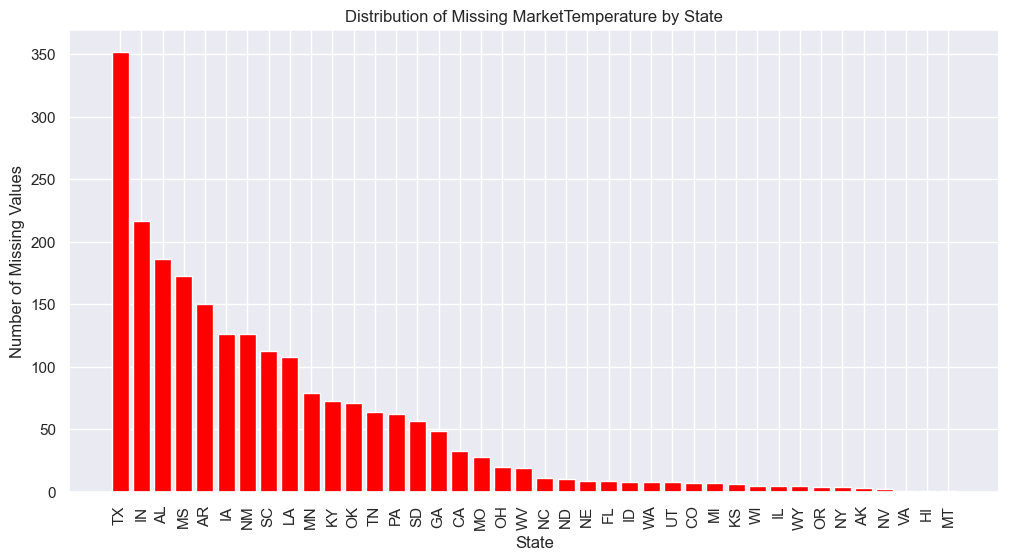

In [17]:
#Plot the number of missing values for the Market tamperature for each state
missing_market_temp_by_state = market_temp[market_temp['MarketTemperature'].isna()]['StateName'].value_counts()

plt.figure(figsize=(12, 6))
plt.bar(missing_market_temp_by_state.index, missing_market_temp_by_state.values, color='red')
plt.xlabel('State')
plt.ylabel('Number of Missing Values')
plt.title('Distribution of Missing MarketTemperature by State')
plt.xticks(rotation=90)
plt.show()

           Missing Count  Missing %
StateName                          
MS                 173.0       9.93
AL                 186.0       8.96
AR                 150.0       8.61
SC                 113.0       8.51
NM                 126.0       7.99
IA                 126.0       6.90
IN                 217.0       6.88
LA                 108.0       6.85
SD                  57.0       6.24
TX                 352.0       5.97
KY                  73.0       4.19
MN                  79.0       4.14
OK                  71.0       4.07
TN                  64.0       2.86
WV                  19.0       2.86
PA                  62.0       2.13
ND                  10.0       1.72
GA                  49.0       1.60
MO                  28.0       1.35
CA                  33.0       1.17


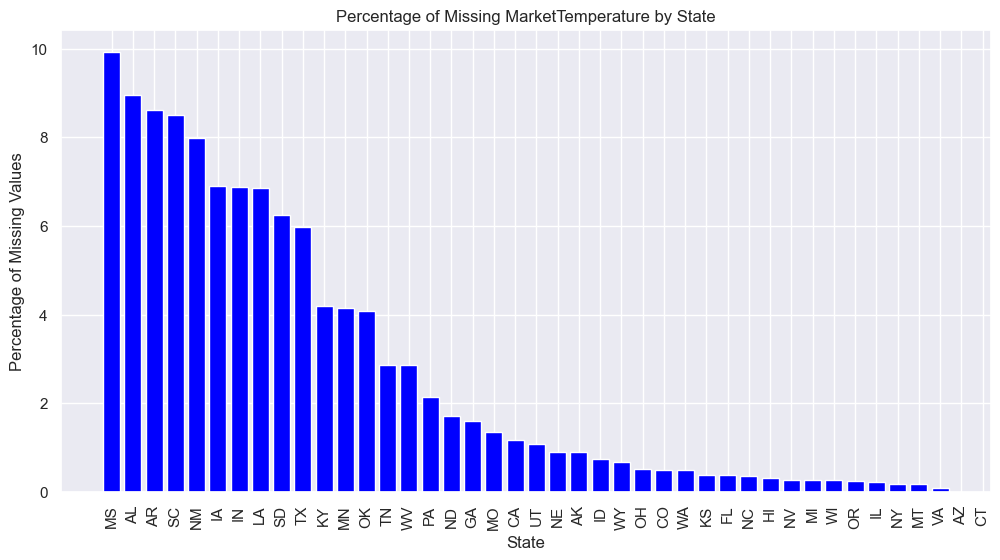

In [18]:
#Plot the % of missing values for the Market tamperature for each state.

#Count the number observations for each state
state_name_count= market_temp['StateName'].value_counts()

#Compute the perceentage of missing values for the market temperature for each state
missing_market_temp_percentage = (missing_market_temp_by_state / state_name_count * 100).round(2)

# Create the dataframe
missing_market_temp_df = pd.DataFrame({'Missing Count':missing_market_temp_by_state , 'Missing %': missing_market_temp_percentage})
missing_market_temp_df = missing_market_temp_df.sort_values(by='Missing %', ascending=False)

#print first results
print(missing_market_temp_df.head(20))

#Plot the % of missing values

plt.figure(figsize=(12, 6))
plt.bar(missing_market_temp_df.index, missing_market_temp_df['Missing %'], color='blue')
plt.xlabel('State')
plt.ylabel('Percentage of Missing Values')
plt.title('Percentage of Missing MarketTemperature by State')
plt.xticks(rotation=90)
plt.show()

In [19]:
#FIXING MISSING VALUES

#missing values for market temperature feature are filled with the previous value corresponding to the same state ('ffill'= firward fill)
#since forward fill may present problem if the first value is nan, we use it in combination with ('bfill'= backward fill) which takes the next values.

market_temp['MarketTemperature'] = market_temp.groupby('StateName')['MarketTemperature'].fillna(method='ffill')
market_temp['MarketTemperature'] = market_temp.groupby('StateName')['MarketTemperature'].fillna(method='bfill')


C:\Users\loren\AppData\Local\Temp\ipykernel_11340\742723274.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  market_temp['MarketTemperature'] = market_temp.groupby('StateName')['MarketTemperature'].fillna(method='ffill')
C:\Users\loren\AppData\Local\Temp\ipykernel_11340\742723274.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  market_temp['MarketTemperature'] = market_temp.groupby('StateName')['MarketTemperature'].fillna(method='bfill')


In [20]:
print(f"There are {market_temp[market_temp['MarketTemperature'].isna()].shape[0]} missing values for the market temperature feature.")
display(market_temp[market_temp['MarketTemperature'].isna()])

There are 0 missing values for the market temperature feature.


,RegionID,SizeRank,RegionName,RegionType,StateName,MarketTemperature
Date,,,,,,


## Median Sales price

The median sale price datset provides information on the middle value in a sorted list of house prices for a given area. This value indicator is usefull both for comparing different regional markets and understand trends in property values over time. The median value is preferred over the mean in housing price analysis because it is less influenced by outliers, such as very expensive or unusually low-priced properties.

The madian sale price is provided on a daily basis for each region (also defined as msa - metropolitan statistical areas- ) of the different US states.


**Median Sales Price**

| **Attribute**                  | **Value**              |
| ------------------------------ | ---------------------- |
| **Time window**                | Feb 2008 - Oct 2024    |
| **Train Set**                   |  Feb 2008 - Dic 2021    |
|**Test Set**                     |Jan 2022 - Oct 2024    |
| **Time Granularity**           | Monthly (end of the Month)                  |
| **Number of Regions**          | 713                    |
| **Number of States**           | 50                     |
| **Number of observations**     | 143,313                |
| **Number of missing values**   | 27,447                 |


### Loading median sale price dataset



In [21]:
median_sale_price=pd.read_csv('Median_sale_price_uc_month.csv')
median_sale_price

,RegionID,SizeRank,RegionName,RegionType,StateName,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
0,102001,0,United States,country,NaN,170922.0,175612.0,177500.0,180000.0,185000.0,...,324000.0,335000.0,345000.0,350000.0,360000.0,369000.0,361000.0,360000.0,350500.0,355000.0
1,394913,1,"New York, NY",msa,NY,397000.0,390000.0,390000.0,390000.0,399900.0,...,570000.0,565000.0,575000.0,585000.0,615000.0,640000.0,649450.0,640000.0,625000.0,624451.0
2,753899,2,"Los Angeles, CA",msa,CA,470000.0,455000.0,457000.0,440000.0,435000.0,...,865000.0,915000.0,916250.0,950000.0,970000.0,960000.0,950500.0,932000.0,915000.0,941000.0
3,394463,3,"Chicago, IL",msa,IL,216750.0,220000.0,221000.0,227000.0,235000.0,...,279000.0,285000.0,300000.0,315000.0,325000.0,337275.0,330000.0,320000.0,317881.0,315000.0
4,394514,4,"Dallas, TX",msa,TX,138000.0,146000.0,144950.0,150000.0,156000.0,...,368000.0,380000.0,390000.0,400000.0,405000.0,400000.0,395000.0,390000.0,380000.0,384000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,394869,869,"Moberly, MO",msa,MO,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,139000.0,152000.0,163250.0,180500.0,186000.0,46338.0,185900.0
709,394371,891,"Beatrice, NE",msa,NE,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200000.0
710,753914,908,"Port Lavaca, TX",msa,TX,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,177884.0,209255.0,103075.0,140948.0
711,395003,912,"Price, UT",msa,UT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,228500.0,305000.0


In [22]:
median_sale_price.shape

(713, 206)

Once the dataset has been loaded, we notice that 201 columns (column 5-206) are dates. In order to perform further time series analysis it is necessary to have these columns as indexes.

In [23]:
median_sale_price = median_sale_price.melt(
    id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName'],  # Colonne fisse
    var_name='Date',  # Nome della colonna con le date
    value_name='MedianSalesPrice'  # Nome della colonna con i valori dei prezzi medi di vendita
)

# Converte la colonna 'Date' in formato datetime
median_sale_price['Date'] = pd.to_datetime(median_sale_price['Date'])

# Imposta la colonna 'Date' come indice
median_sale_price.set_index('Date', inplace=True)

# Controlla il risultato
print(median_sale_price.head())
print(median_sale_price.index)

            RegionID  SizeRank       RegionName RegionType StateName  \
Date                                                                   
2008-02-29    102001         0    United States    country       NaN   
2008-02-29    394913         1     New York, NY        msa        NY   
2008-02-29    753899         2  Los Angeles, CA        msa        CA   
2008-02-29    394463         3      Chicago, IL        msa        IL   
2008-02-29    394514         4       Dallas, TX        msa        TX   

            MedianSalesPrice  
Date                          
2008-02-29          170922.0  
2008-02-29          397000.0  
2008-02-29          470000.0  
2008-02-29          216750.0  
2008-02-29          138000.0  
DatetimeIndex(['2008-02-29', '2008-02-29', '2008-02-29', '2008-02-29',
               '2008-02-29', '2008-02-29', '2008-02-29', '2008-02-29',
               '2008-02-29', '2008-02-29',
               ...
               '2024-10-31', '2024-10-31', '2024-10-31', '2024-10-31',
   

In [24]:
median_sale_price.head(10)

,RegionID,SizeRank,RegionName,RegionType,StateName,MedianSalesPrice
Date,,,,,,
2008-02-29,102001,0,United States,country,NaN,170922.0
2008-02-29,394913,1,"New York, NY",msa,NY,397000.0
2008-02-29,753899,2,"Los Angeles, CA",msa,CA,470000.0
2008-02-29,394463,3,"Chicago, IL",msa,IL,216750.0
2008-02-29,394514,4,"Dallas, TX",msa,TX,138000.0
2008-02-29,394692,5,"Houston, TX",msa,TX,145000.0
2008-02-29,395209,6,"Washington, DC",msa,VA,339000.0
2008-02-29,394974,7,"Philadelphia, PA",msa,PA,190000.0
2008-02-29,394856,8,"Miami, FL",msa,FL,238000.0


In [25]:
median_sale_price.index.unique()

DatetimeIndex(['2008-02-29', '2008-03-31', '2008-04-30', '2008-05-31',
               '2008-06-30', '2008-07-31', '2008-08-31', '2008-09-30',
               '2008-10-31', '2008-11-30',
               ...
               '2024-01-31', '2024-02-29', '2024-03-31', '2024-04-30',
               '2024-05-31', '2024-06-30', '2024-07-31', '2024-08-31',
               '2024-09-30', '2024-10-31'],
              dtype='datetime64[ns]', name='Date', length=201, freq=None)

Now the dataset has a correct structure: for each RegionID, which are 713 overall, we have all the 201 recordings of the median sale price measured in different time instants. We expect 713 * 201 = 143313 rows.

In [26]:
print(f'The new datset stracture is:{median_sale_price.shape}')
print(f'As expected, the total number of rows is: {median_sale_price.shape[0]}')

The new datset stracture is:(143313, 6)
As expected, the total number of rows is: 143313


### Columns exploration

* Region ID: **unique identifier of the table**. It assigns an id for each US region. Region id 102001 does not correspond to a single region but to  United States country.
* Size rank: ranks the regions from the most populated to the lest populated.
* Region Name: associates a name to the specific region id number. Id 102001 corresponds to United States country.
* Region Type: binary varibable.
  * 'country' the observation is associated to United States country.
  * 'msa' the observation is associated to a specific metropolitan statistical area.
* State Name: name of the specific state the region belongs to. If the recording has Region Name = United States the State Name is nan.
* Median Sales Price: value of the market temperature index.

In [27]:
median_sale_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143313 entries, 2008-02-29 to 2024-10-31
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   RegionID          143313 non-null  int64  
 1   SizeRank          143313 non-null  int64  
 2   RegionName        143313 non-null  object 
 3   RegionType        143313 non-null  object 
 4   StateName         143112 non-null  object 
 5   MedianSalesPrice  115866 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 11.7+ MB


In [28]:
#regionid exploration
print(f"There are {len(median_sale_price['RegionID'].unique())} regions")

There are 713 regions


In [29]:
#as in the market temperature table, Region id 102001 does not correspond to a single region but to United States country
median_sale_price[median_sale_price['RegionID']==102001]

,RegionID,SizeRank,RegionName,RegionType,StateName,MedianSalesPrice
Date,,,,,,
2008-02-29,102001,0,United States,country,NaN,170922.0
2008-03-31,102001,0,United States,country,NaN,175612.0
2008-04-30,102001,0,United States,country,NaN,177500.0
2008-05-31,102001,0,United States,country,NaN,180000.0
2008-06-30,102001,0,United States,country,NaN,185000.0
...,...,...,...,...,...,...
2024-06-30,102001,0,United States,country,NaN,369000.0
2024-07-31,102001,0,United States,country,NaN,361000.0
2024-08-31,102001,0,United States,country,NaN,360000.0


In [30]:
#size rank exploration: this variable ranks the regions from the most populated to the less populated.
#In the overall ranking some position are missing.

print(f"Number of unique values: {len(median_sale_price['SizeRank'].unique())}")

#some values in the rank are missing
missing_values_in_size_rank_median_sales = set(range(0, 720)) - set(median_sale_price['SizeRank'])

print("Missing values in the size rank:", sorted(missing_values_in_size_rank_median_sales))

Number of unique values: 711
Missing values in the size rank: [33, 139, 166, 204, 238, 245, 256, 269, 333, 344, 346, 355, 362, 369, 371, 395, 407, 423, 425, 434, 435, 444, 458, 466, 480, 487, 493, 499, 503, 508, 512, 529, 531, 547, 552, 559, 563, 569, 592, 595, 596, 599, 605, 609, 611, 613, 618, 620, 622, 623, 625, 636, 637, 642, 646, 648, 651, 653, 661, 662, 667, 669, 679, 680, 685, 688, 689, 693, 694, 695, 699, 706, 707, 713, 717]


In [31]:
#region name exploration. The total number of region names corresponds to the number of region id.
print(f" There are {len(median_sale_price['RegionName'].unique())} region names")

print(f"First region names are: {median_sale_price['RegionName'].unique()[0:10]}")

 There are 713 region names
First region names are: ['United States' 'New York, NY' 'Los Angeles, CA' 'Chicago, IL'
 'Dallas, TX' 'Houston, TX' 'Washington, DC' 'Philadelphia, PA'
 'Miami, FL' 'Atlanta, GA']


In [32]:
#region type exploration. It is a binary variable, indicating whether the recordings concernes a metropolitan area or to the all US country.
print(median_sale_price['RegionType'].unique())
print(f"the number of region types is: {len(median_sale_price['RegionType'].unique())}")

['country' 'msa']
the number of region types is: 2


In [33]:
#state name exploration
print(f"There are {len(median_sale_price['StateName'].unique())} state names")

print(f"First state names are: {median_sale_price['StateName'].unique()[0:10]}")

There are 50 state names
First state names are: [nan 'NY' 'CA' 'IL' 'TX' 'VA' 'PA' 'FL' 'GA' 'MA']


In [34]:
#we detect a nan state, it is associated to aggregated US data.
median_sale_price[median_sale_price['StateName'].isna()]

,RegionID,SizeRank,RegionName,RegionType,StateName,MedianSalesPrice
Date,,,,,,
2008-02-29,102001,0,United States,country,NaN,170922.0
2008-03-31,102001,0,United States,country,NaN,175612.0
2008-04-30,102001,0,United States,country,NaN,177500.0
2008-05-31,102001,0,United States,country,NaN,180000.0
2008-06-30,102001,0,United States,country,NaN,185000.0
...,...,...,...,...,...,...
2024-06-30,102001,0,United States,country,NaN,369000.0
2024-07-31,102001,0,United States,country,NaN,361000.0
2024-08-31,102001,0,United States,country,NaN,360000.0


In [35]:
#we replace nan values for state name with USA
median_sale_price['StateName'].fillna('USA', inplace=True)

print('now there are no nan values')
display(median_sale_price[median_sale_price['StateName'].isna()])
print('Nan values for State Name feature are replaced with USA')
display(median_sale_price[median_sale_price['StateName']=='USA'])


now there are no nan values


,RegionID,SizeRank,RegionName,RegionType,StateName,MedianSalesPrice
Date,,,,,,


Nan values for State Name feature are replaced with USA


,RegionID,SizeRank,RegionName,RegionType,StateName,MedianSalesPrice
Date,,,,,,
2008-02-29,102001,0,United States,country,USA,170922.0
2008-03-31,102001,0,United States,country,USA,175612.0
2008-04-30,102001,0,United States,country,USA,177500.0
2008-05-31,102001,0,United States,country,USA,180000.0
2008-06-30,102001,0,United States,country,USA,185000.0
...,...,...,...,...,...,...
2024-06-30,102001,0,United States,country,USA,369000.0
2024-07-31,102001,0,United States,country,USA,361000.0
2024-08-31,102001,0,United States,country,USA,360000.0


In [36]:
#MEDIAN SALES PRICE EXPLORATION

#evaluate how many missing values are present and how they are distributed

print(f"There are {median_sale_price[median_sale_price['MedianSalesPrice'].isna()].shape[0]} missing values for the median sale price feature.")
display(median_sale_price[median_sale_price['MedianSalesPrice'].isna()])



There are 27447 missing values for the median sale price feature.


,RegionID,SizeRank,RegionName,RegionType,StateName,MedianSalesPrice
Date,,,,,,
2008-02-29,845159,86,"Poughkeepsie, NY",msa,NY,NaN
2008-02-29,394421,130,"Brownsville, TX",msa,TX,NaN
2008-02-29,395197,178,"Waco, TX",msa,TX,NaN
2008-02-29,395103,182,"Sioux Falls, SD",msa,SD,NaN
2008-02-29,394772,187,"Laredo, TX",msa,TX,NaN
...,...,...,...,...,...,...
2024-08-31,394371,891,"Beatrice, NE",msa,NE,NaN
2024-08-31,395003,912,"Price, UT",msa,UT,NaN
2024-09-30,394343,521,"Athens, OH",msa,OH,NaN


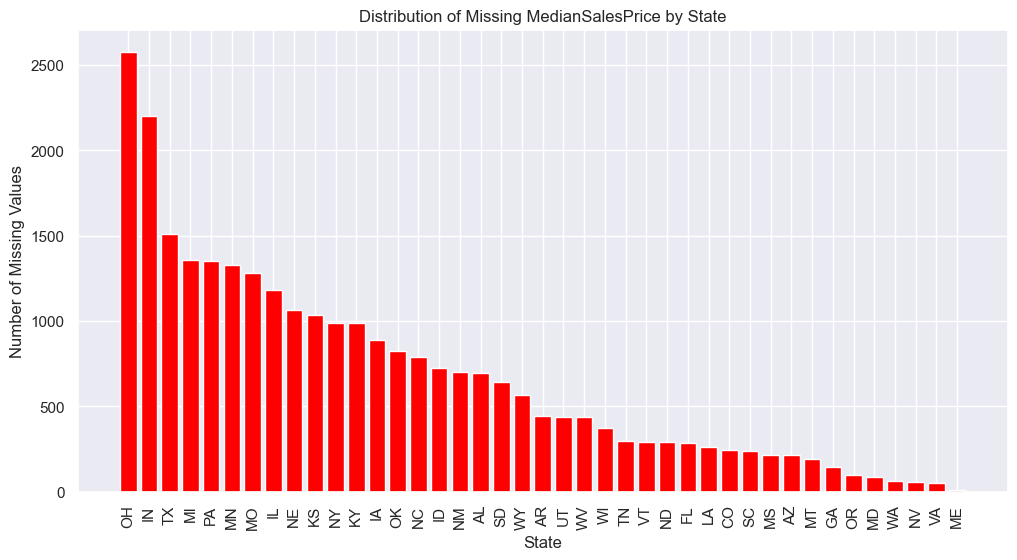

In [37]:
#Plot the number of missing values for the median sale price for each state
missing_median_sale_price_by_state = median_sale_price[median_sale_price['MedianSalesPrice'].isna()]['StateName'].value_counts()

plt.figure(figsize=(12, 6))
plt.bar(missing_median_sale_price_by_state.index, missing_median_sale_price_by_state.values, color='red')
plt.xlabel('State')
plt.ylabel('Number of Missing Values')
plt.title('Distribution of Missing MedianSalesPrice by State')
plt.xticks(rotation=90)
plt.show()

           Missing Count  Missing %
StateName                          
SD                 641.0      63.78
NE                1064.0      58.82
WY                 564.0      56.12
KS                1038.0      46.95
MN                1329.0      38.89
WV                 438.0      36.32
VT                 291.0      36.19
ND                 291.0      36.19
ID                 725.0      36.07
IN                2201.0      35.32
NM                 702.0      34.93
MO                1284.0      31.94
KY                 986.0      30.66
OH                2578.0      30.54
IA                 887.0      29.42
OK                 827.0      27.43
IL                1185.0      24.56
UT                 440.0      24.32
TX                1513.0      22.14
MI                1356.0      21.76


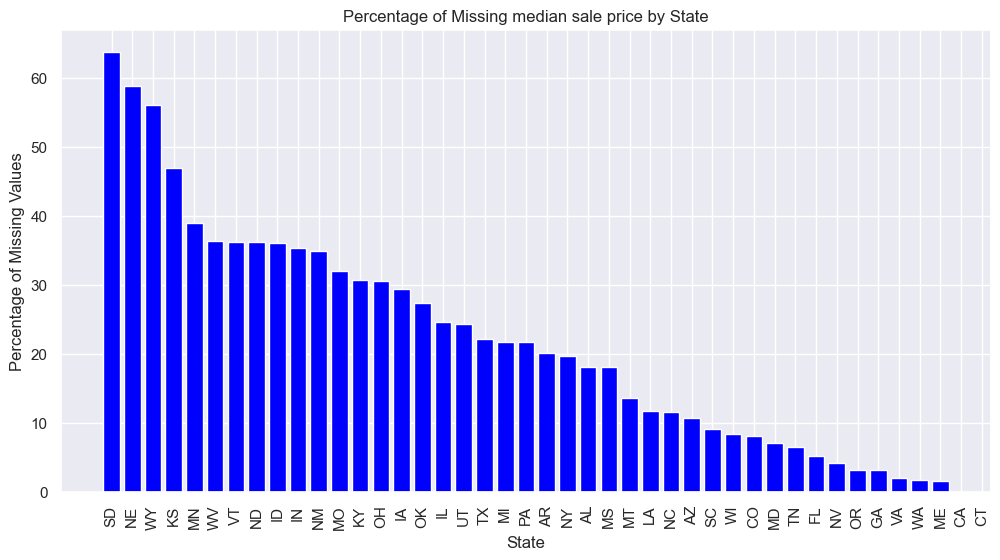

In [38]:
#Plot the % of missing values for the median sale price for each state.

#Count the number observations for each state
state_name_count_median_sale= median_sale_price['StateName'].value_counts()

#Compute the perceentage of missing values for the median sale price for each state
missing_median_sale_percentage = (missing_median_sale_price_by_state / state_name_count_median_sale * 100).round(2)

# Create the dataframe
missing_median_sale_df = pd.DataFrame({'Missing Count':missing_median_sale_price_by_state , 'Missing %': missing_median_sale_percentage})
missing_median_sale_df = missing_median_sale_df.sort_values(by='Missing %', ascending=False)

#print first results
print(missing_median_sale_df.head(20))

#Plot the % of missing values 

plt.figure(figsize=(12, 6))
plt.bar(missing_median_sale_df.index, missing_median_sale_df['Missing %'], color='blue')
plt.xlabel('State')
plt.ylabel('Percentage of Missing Values')
plt.title('Percentage of Missing median sale price by State')
plt.xticks(rotation=90)
plt.show()

In [39]:
total_missing_count = missing_median_sale_df['Missing Count'].sum()
print(total_missing_count)

27447.0


Differently from the market temperature index dataframe, the median sale price contains a lot of missing values (same of the states have until 60% of missing values).
However, the approach to fill missing value is the same adopted before: every missing value for the median sale price index is replaced with the following one in order of time, considering the same state.
**For further analysis and forecasting, states with starting high percentage of missing values will be exluded.**

In [40]:
#FIXING MISSING VALUES

#missing values for median sale price feature are filled with the previous value corresponding to the same state ('ffill'= firward fill)
#since forward fill may present problem if the first value is nan, we use it in combination with ('bfill'= backward fill) which takes the next values.

median_sale_price['MedianSalesPrice'] = median_sale_price.groupby('StateName')['MedianSalesPrice'].fillna(method='ffill')
median_sale_price['MedianSalesPrice'] = median_sale_price.groupby('StateName')['MedianSalesPrice'].fillna(method='bfill')

C:\Users\loren\AppData\Local\Temp\ipykernel_11340\4259984554.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  median_sale_price['MedianSalesPrice'] = median_sale_price.groupby('StateName')['MedianSalesPrice'].fillna(method='ffill')
C:\Users\loren\AppData\Local\Temp\ipykernel_11340\4259984554.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  median_sale_price['MedianSalesPrice'] = median_sale_price.groupby('StateName')['MedianSalesPrice'].fillna(method='bfill')


In [41]:
print(f"There are {median_sale_price[median_sale_price['MedianSalesPrice'].isna()].shape[0]} missing values for the median sale price feature.")
display(median_sale_price[median_sale_price['MedianSalesPrice'].isna()])

There are 0 missing values for the median sale price feature.


,RegionID,SizeRank,RegionName,RegionType,StateName,MedianSalesPrice
Date,,,,,,


# Section 2 -Dataset Exploration-

## Split Train and Test
We perform train-test splitting for the median sale price dataset:
* TRAIN: Feb 2008-Dic 2021
* TEST: Jan 2022- Oct 2024

In [42]:
median_sale_price_train=median_sale_price[median_sale_price.index< '2021-12-31']
median_sale_price_test=median_sale_price[median_sale_price.index >='2022-01-01']

display(median_sale_price_train.index.year.unique())
display(median_sale_price_test.index.year.unique())

Index([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021],
      dtype='int32', name='Date')

Index([2022, 2023, 2024], dtype='int32', name='Date')

Before diving in exploratory data analysis, it was deemed necessary to create two subset datasets, both for the market temperature and the median hosue pricing:
1. **market_temp_agg**: contains aggregated values at the country level (StateName = USA) for the market temperature.
2. **market_temp_states** contains data for single state values (i.e StateName= FL) for the market temperature.
___
1. **median_sale_price_train_agg**: contains aggregated values at the country level (StateName = USA) for the median house pricing.
2. **median_sale_price_train_states** contains data for single state values (i.e StateName= FL) for the median house pricing.

In [43]:
market_temp_agg=market_temp[market_temp['StateName']=='USA']
market_temp_states=market_temp[market_temp['StateName']!='USA']

median_sale_price_train_agg= median_sale_price_train[median_sale_price_train['StateName']=='USA']
median_sale_price_train_states= median_sale_price_train[median_sale_price_train['StateName']!='USA']


In [44]:
median_sale_price_train_agg

,RegionID,SizeRank,RegionName,RegionType,StateName,MedianSalesPrice
Date,,,,,,
2008-02-29,102001,0,United States,country,USA,241500.0
2008-03-31,102001,0,United States,country,USA,225000.0
2008-04-30,102001,0,United States,country,USA,220000.0
2008-05-31,102001,0,United States,country,USA,210000.0
2008-06-30,102001,0,United States,country,USA,198000.0
...,...,...,...,...,...,...
2021-07-31,102001,0,United States,country,USA,420000.0
2021-08-31,102001,0,United States,country,USA,423000.0
2021-09-30,102001,0,United States,country,USA,425000.0


### Line Plot

We first start by looking at the aggregated data.

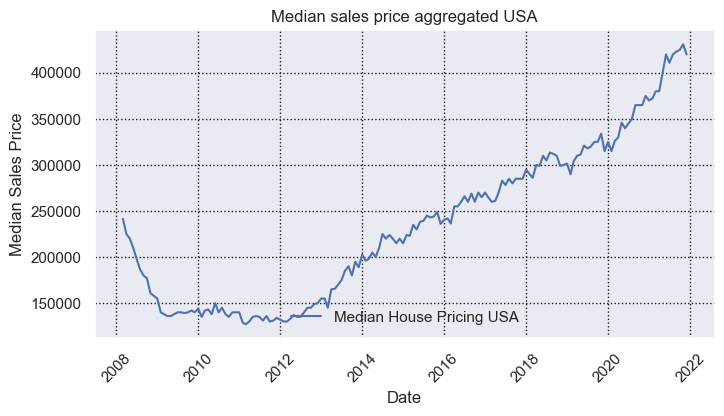

In [45]:
plt.figure(figsize=(8, 4))
plt.plot(median_sale_price_train_agg.index, median_sale_price_train_agg['MedianSalesPrice'], label='Median House Pricing USA')

plt.grid(True, color='k', linestyle=':')
plt.title('Median sales price aggregated USA')
plt.xlabel('Date')
plt.ylabel('Median Sales Price') 
plt.legend(frameon=False, loc='lower center', ncol=2)
plt.xticks(rotation=45)  

plt.show()


As illustrated in the next plot, the aggregated time series for median sale price exhibits a pattern that closely mirrors the trends observed in individual state time series. Therefore, the insights derived at the aggregated level can also be considered applicable to individual states.

For the next plot 3 states from different geographical regions are considered.


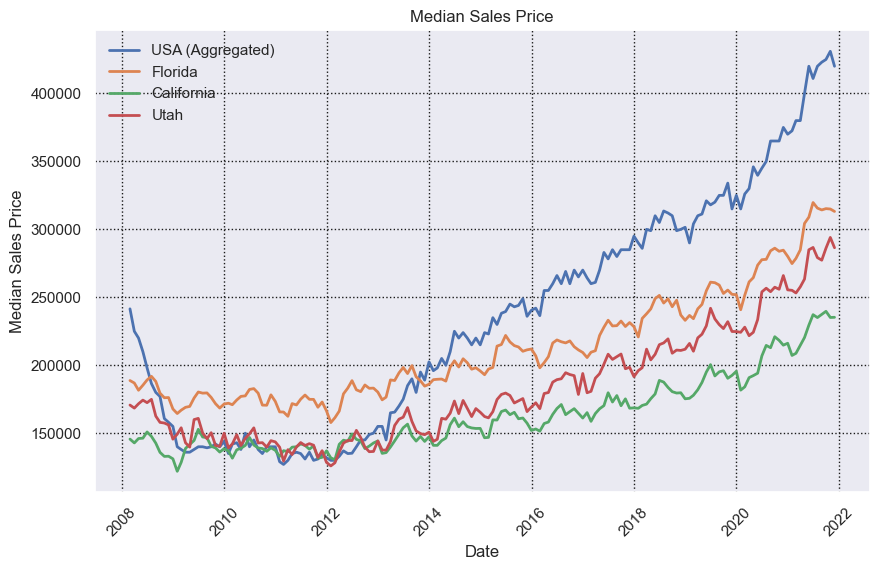

In [46]:
#FLORIDA
median_sale_price_train_FL=median_sale_price_train[median_sale_price_train['StateName']=='FL']
median_sale_price_train_FL= median_sale_price_train_FL[['MedianSalesPrice']].groupby(median_sale_price_train_FL.index).mean()
#CALIFORINA
median_sale_price_train_CA=median_sale_price_train[median_sale_price_train['StateName']=='CA']
median_sale_price_train_CA= median_sale_price_train_CA[['MedianSalesPrice']].groupby(median_sale_price_train_CA.index).mean()
#UTAH
median_sale_price_train_UT=median_sale_price_train[median_sale_price_train['StateName']=='UT']
median_sale_price_train_UT= median_sale_price_train_UT[['MedianSalesPrice']].groupby(median_sale_price_train_UT.index).mean()

# Creiamo il grafico con 4 linee: aggregato + 3 stati (FL, CA, UT)
plt.figure(figsize=(10, 6))

# Linea per l'aggregato USA
plt.plot(median_sale_price_train_agg.index, median_sale_price_train_agg['MedianSalesPrice'], label='USA (Aggregated)', linewidth=2)

# Linea per la Florida
plt.plot(median_sale_price_train_FL.index, median_sale_price_train_FL['MedianSalesPrice'], label='Florida', linestyle='-', linewidth=2)

# Linea per la California
plt.plot(median_sale_price_train_CA.index, median_sale_price_train_CA['MedianSalesPrice'], label='California', linestyle='-', linewidth=2)

# Linea per lo Utah
plt.plot(median_sale_price_train_UT.index, median_sale_price_train_UT['MedianSalesPrice'], label='Utah', linestyle='-', linewidth=2)

# Personalizzazione del grafico
plt.grid(True, color='k', linestyle=':')
plt.title('Median Sales Price')
plt.xlabel('Date')
plt.ylabel('Median Sales Price')
plt.legend(frameon=False, loc='upper left')
plt.xticks(rotation=45)

# Mostriamo il grafico
plt.show()

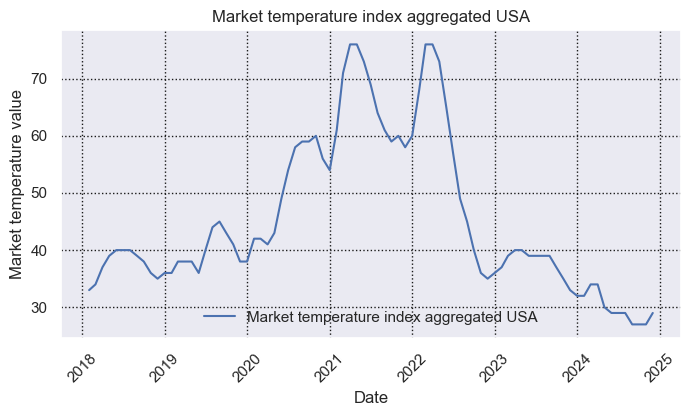

In [47]:
#Plot the market temperature index

plt.figure(figsize=(8, 4))
plt.plot(market_temp_agg.index, market_temp_agg['MarketTemperature'], label='Market temperature index aggregated USA')

plt.grid(True, color='k', linestyle=':')
plt.title('Market temperature index aggregated USA')
plt.xlabel('Date')
plt.ylabel('Market temperature value') 
plt.legend(frameon=False, loc='lower center', ncol=2)
plt.xticks(rotation=45)  

plt.show()

We now consider the same time frame 2018-2024

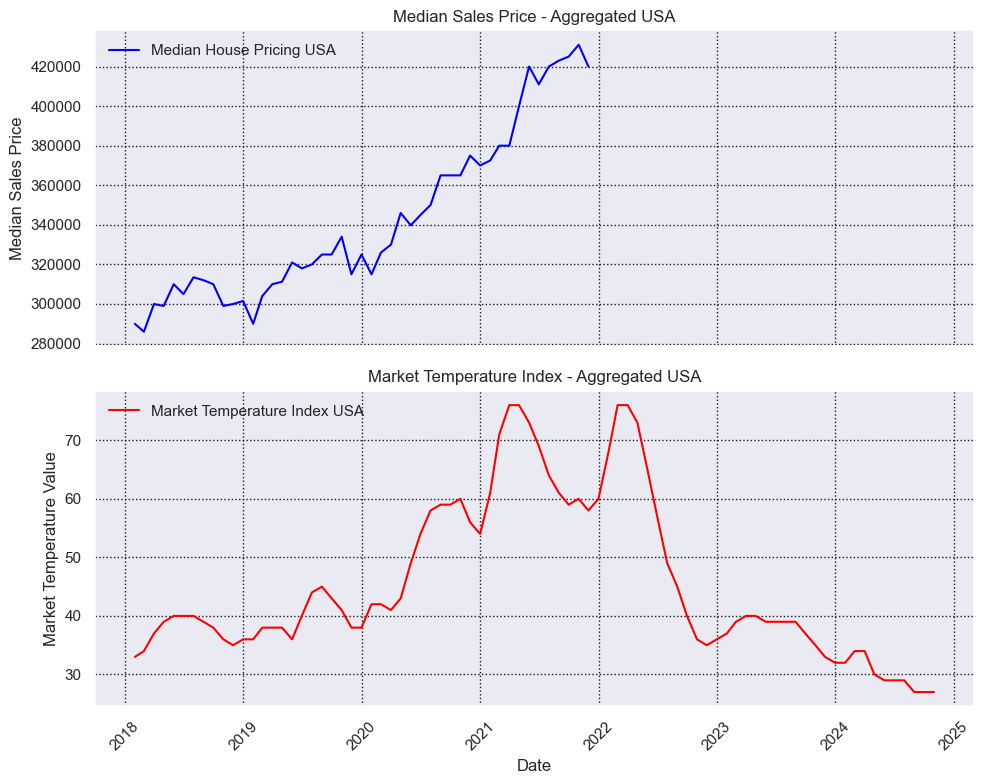

In [48]:
start_date = '2018-01-31'
end_date = '2024-10-31'

#create new subsets of the original df considering the same timeset
median_sale_price_train_agg_filtered = median_sale_price_train_agg.loc[start_date:end_date]
market_temp_agg_filtered = market_temp_agg.loc[start_date:end_date]

#crate subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)


axes[0].plot(median_sale_price_train_agg_filtered.index, median_sale_price_train_agg_filtered['MedianSalesPrice'], label='Median House Pricing USA', color='blue')
axes[0].set_title('Median Sales Price - Aggregated USA')
axes[0].set_ylabel('Median Sales Price')
axes[0].grid(True, color='k', linestyle=':')
axes[0].legend(frameon=False, loc='upper left')

axes[1].plot(market_temp_agg_filtered.index, market_temp_agg_filtered['MarketTemperature'], label='Market Temperature Index USA', color='red')
axes[1].set_title('Market Temperature Index - Aggregated USA')
axes[1].set_ylabel('Market Temperature Value')
axes[1].grid(True, color='k', linestyle=':')
axes[1].legend(frameon=False, loc='upper left')

plt.xticks(rotation=45)
axes[1].set_xlabel('Date')
plt.tight_layout()
plt.show()


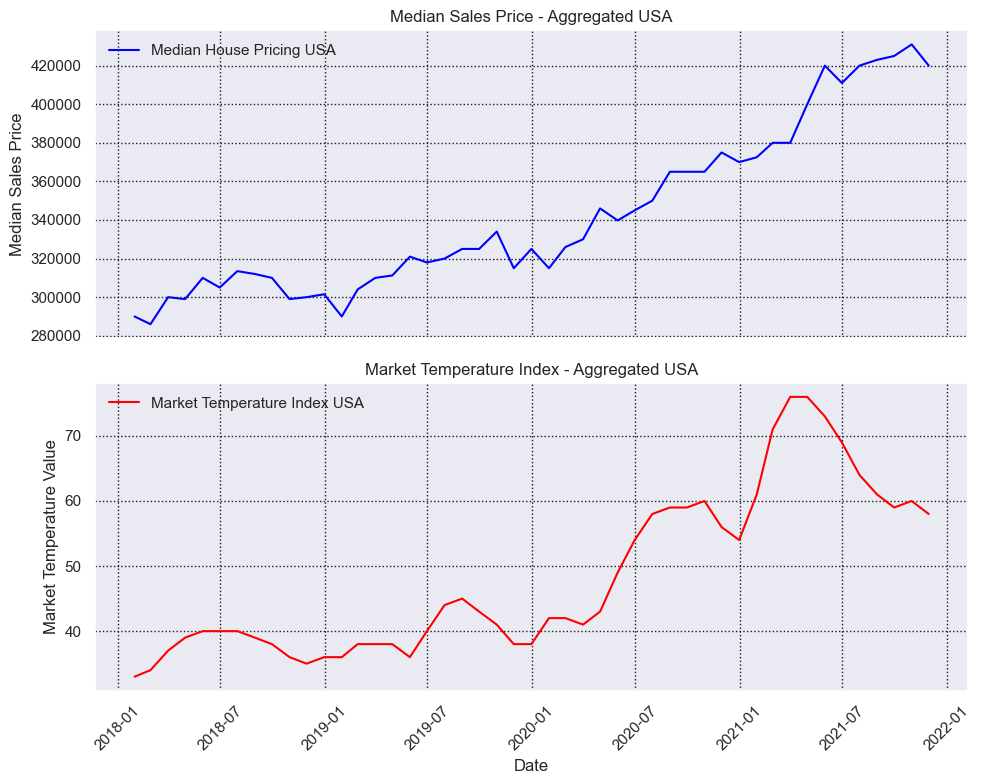

In [49]:
start_date = '2018-01-31'
end_date = '2024-10-31'

# Filtriamo entrambe le serie temporali con lo stesso intervallo di date
median_sale_price_train_agg_filtered = median_sale_price_train_agg.loc[start_date:end_date]

# Assicuriamoci che il Market Temperature Index abbia lo stesso range di date
market_temp_agg_filtered = market_temp_agg.loc[median_sale_price_train_agg_filtered.index]

# Creazione subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

axes[0].plot(
    median_sale_price_train_agg_filtered.index,
    median_sale_price_train_agg_filtered['MedianSalesPrice'],
    label='Median House Pricing USA',
    color='blue'
)
axes[0].set_title('Median Sales Price - Aggregated USA')
axes[0].set_ylabel('Median Sales Price')
axes[0].grid(True, color='k', linestyle=':')
axes[0].legend(frameon=False, loc='upper left')

axes[1].plot(
    market_temp_agg_filtered.index,
    market_temp_agg_filtered['MarketTemperature'],
    label='Market Temperature Index USA',
    color='red'
)
axes[1].set_title('Market Temperature Index - Aggregated USA')
axes[1].set_ylabel('Market Temperature Value')
axes[1].grid(True, color='k', linestyle=':')
axes[1].legend(frameon=False, loc='upper left')

plt.xticks(rotation=45)
axes[1].set_xlabel('Date')
plt.tight_layout()
plt.show()


We now apply Moving Average smoothing in order to bettere visualize if the two time series have a similar trend-cycle for the same years.

C:\Users\loren\AppData\Local\Temp\ipykernel_11340\4223563398.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  median_sale_price_train_agg_filtered['median_sale_price_agg_5MA']=median_sale_price_train_agg_filtered['MedianSalesPrice'].rolling(5, center=True).mean()


Text(0, 0.5, 'median sale price')

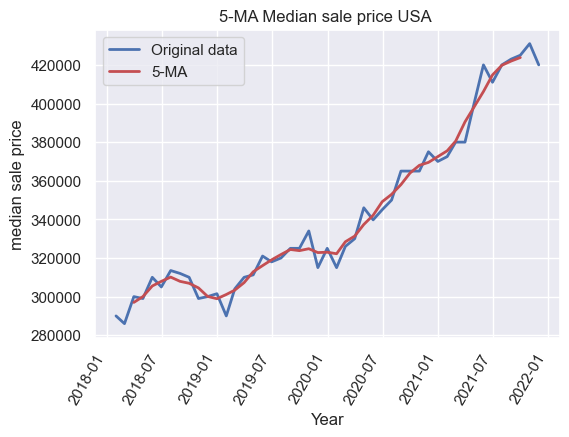

In [50]:
#create a 5-MA on the median sale price USA

median_sale_price_train_agg_filtered['median_sale_price_agg_5MA']=median_sale_price_train_agg_filtered['MedianSalesPrice'].rolling(5, center=True).mean()
median_sale_price_train_agg_filtered

# Visualization of 10-MA
plt.figure(figsize=(6,4))
plt.plot(median_sale_price_train_agg_filtered['MedianSalesPrice'],'b-',label = 'Original data', linewidth=2)
plt.plot(median_sale_price_train_agg_filtered['median_sale_price_agg_5MA'],'r-',label = '5-MA', linewidth=2)
plt.legend()
plt.title('5-MA Median sale price USA ')
plt.xlabel('Year')
plt.xticks(rotation=60, ha='right')
plt.ylabel('median sale price')

Text(0, 0.5, 'market temperature index')

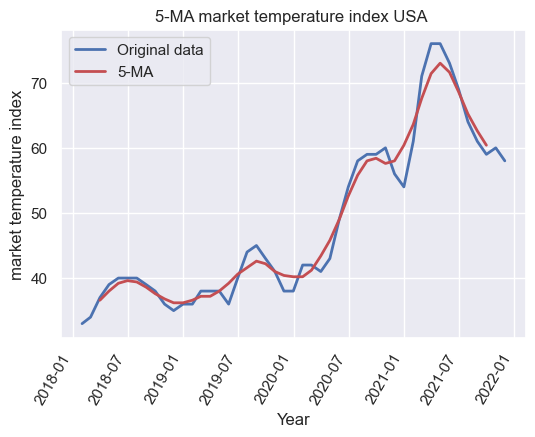

In [51]:
#create a 5-MA for the market temperature index

market_temp_agg_filtered['MarketTemperature_5MA']=market_temp_agg_filtered['MarketTemperature'].rolling(5, center=True).mean()

# Visualization of 5-MA
plt.figure(figsize=(6,4))
plt.plot(market_temp_agg_filtered['MarketTemperature'],'b-',label = 'Original data', linewidth=2)
plt.plot(market_temp_agg_filtered['MarketTemperature_5MA'],'r-',label = '5-MA', linewidth=2)
plt.legend()
plt.title('5-MA market temperature index USA ')
plt.xlabel('Year')
plt.xticks(rotation=60, ha='right')
plt.ylabel('market temperature index')

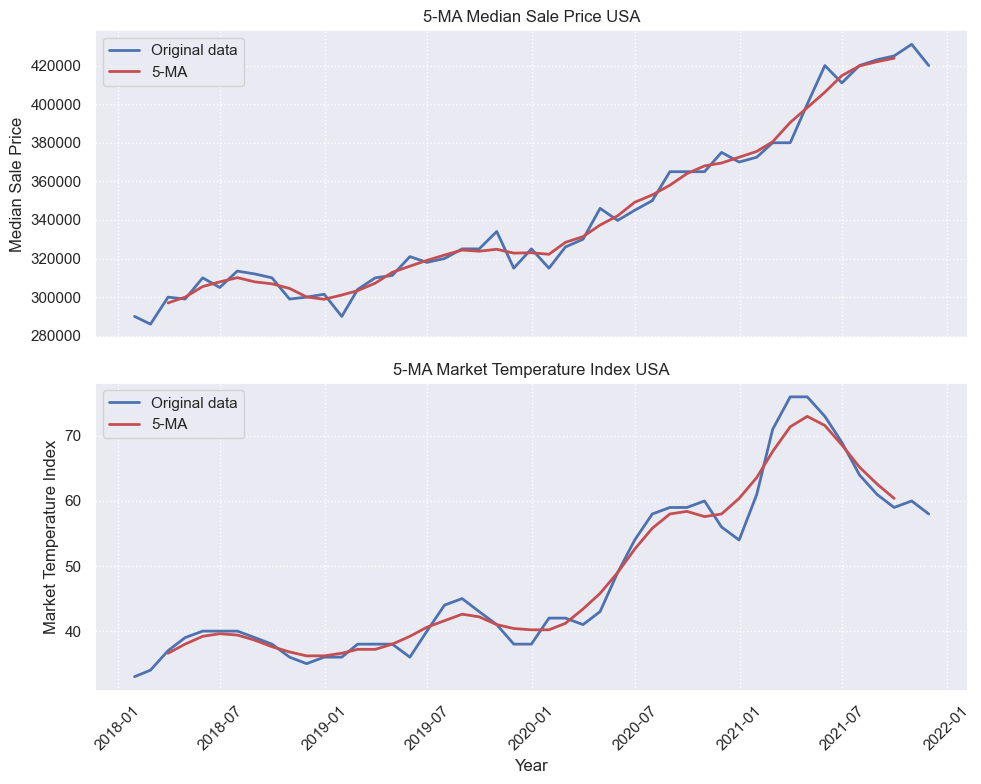

In [52]:
# Ricarico le librerie necessarie dopo il reset
import matplotlib.pyplot as plt
import pandas as pd

# Dati di esempio (visto che il reset ha cancellato i dati)
# Supponiamo che median_sale_price_train_agg_filtered e market_temp_agg_filtered siano già definiti

# Creazione dei subplot
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Primo subplot: 5-MA Median Sales Price
axes[0].plot(median_sale_price_train_agg_filtered.index, 
             median_sale_price_train_agg_filtered['MedianSalesPrice'], 
             'b-', label='Original data', linewidth=2)

axes[0].plot(median_sale_price_train_agg_filtered.index, 
             median_sale_price_train_agg_filtered['median_sale_price_agg_5MA'], 
             'r-', label='5-MA', linewidth=2)

axes[0].set_title('5-MA Median Sale Price USA')
axes[0].set_ylabel('Median Sale Price')
axes[0].grid(True, linestyle=':')
axes[0].legend()

# Secondo subplot: 5-MA Market Temperature Index
axes[1].plot(market_temp_agg_filtered.index, 
             market_temp_agg_filtered['MarketTemperature'], 
             'b-', label='Original data', linewidth=2)

axes[1].plot(market_temp_agg_filtered.index, 
             market_temp_agg_filtered['MarketTemperature_5MA'], 
             'r-', label='5-MA', linewidth=2)

axes[1].set_title('5-MA Market Temperature Index USA')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Market Temperature Index')
axes[1].grid(True, linestyle=':')
axes[1].legend()

# Ottimizzazione del layout
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

AGGIUNGI COMMENTO CHE HANNO UN ANDAMENTO SIMILE FINO AL 2023. POI CONVERGONO!! VERIFICA SUCCESSIVAMENTE LA CORRELAZIONE

### Correlation
We now explore whether or not exists a correlation between the median house price and the market temperature index. What we expect is a positive relation between the 2 variables since better market conditions for the sellers (market temperature) should be reflected in higher prices.

In [53]:
#we consider aggregated data
market_temp_usa = market_temp[market_temp['RegionType'] == 'country'][['MarketTemperature']]
median_sale_price_usa = median_sale_price[median_sale_price['RegionType'] == 'country'][['MedianSalesPrice']]

#we consider the common time window 2018-2024
median_sale_price_usa_2018_2024 = median_sale_price_usa.loc['2018-01-01':'2024-10-31']
market_temp_usa = market_temp_usa.loc['2018-01-01':'2024-10-31']

#merge the dataset on the date
merged_df_entire = median_sale_price_usa_2018_2024.join(market_temp_usa, how='inner')

#plot the results
plt.figure(figsize=(8, 5))
plt.scatter(merged_df['MarketTemperature'], merged_df['MedianSalesPrice'], alpha=0.7, color='blue')
plt.xlabel('Market Temperature')
plt.ylabel('Median Sale Price')
plt.title('Correlation between Market Temperature and Median Sale Price (USA, 2018-2024)')
plt.grid(True, linestyle=':')
plt.show()

NameError: name 'merged_df' is not defined

<Figure size 800x500 with 0 Axes>

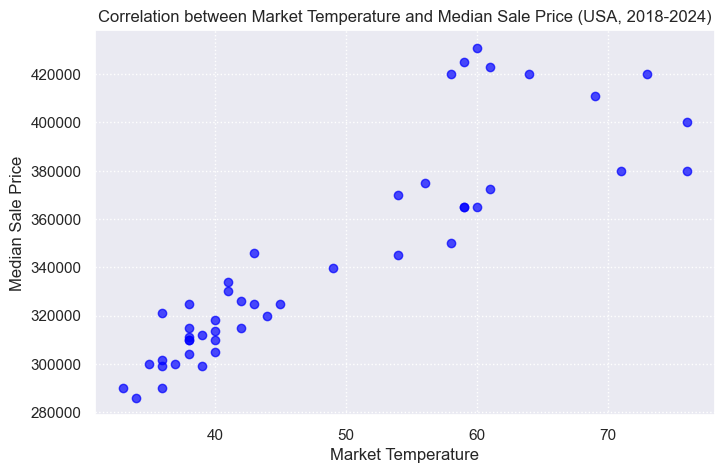

In [ ]:
# Definizione dell'intervallo temporale comune
start_date = '2018-01-31'
end_date = '2024-10-31'

# Filtriamo entrambe le serie temporali con lo stesso intervallo di date
median_sale_price_train_agg_filtered = median_sale_price_train_agg.loc[start_date:end_date]
market_temp_agg_filtered = market_temp_agg.loc[median_sale_price_train_agg_filtered.index]

# Merge dei dataset sulla data per ottenere una tabella con i valori allineati
merged_df = median_sale_price_train_agg_filtered.join(
    market_temp_agg_filtered, 
    how='inner', 
    lsuffix='_sales', 
    rsuffix='_temp'
)

# Creazione dello scatter plot per analizzare la correlazione
plt.figure(figsize=(8, 5))
plt.scatter(merged_df['MarketTemperature'], merged_df['MedianSalesPrice'], alpha=0.7, color='blue')

plt.xlabel('Market Temperature')
plt.ylabel('Median Sale Price')
plt.title('Correlation between Market Temperature and Median Sale Price (USA, 2018-2024)')
plt.grid(True, linestyle=':')
plt.show()



In [ ]:
#Compute correlation
correlation = merged_df[['MarketTemperature', 'MedianSalesPrice']].corr()
correlation

,MarketTemperature,MedianSalesPrice
MarketTemperature,1.000000,0.888722
MedianSalesPrice,0.888722,1.000000


Coorelation between the median sale price and market temperature is high and positive, as expected. However, unit now we have just considered the common time window between the train set of the median sale price and the market temperature (Ja 2018- Dic 2022). However, if we consider the entire median sale price dataset, such correlation decreases.

We first plot the entire datasets.

NameError: name 'merged_df' is not defined

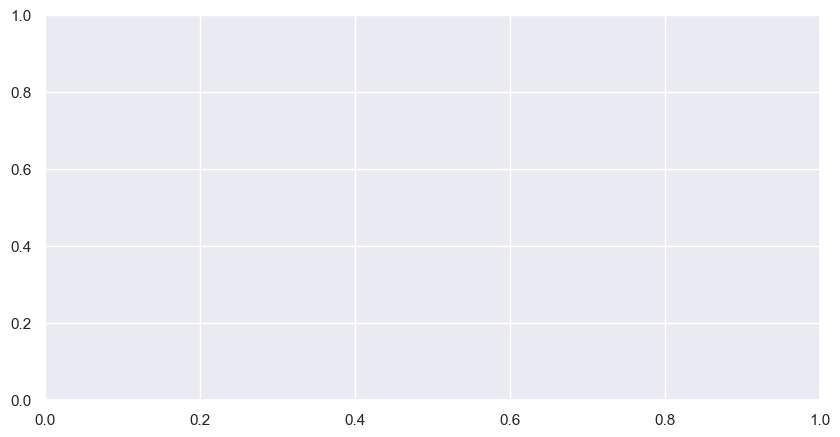

In [54]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(merged_df.index, merged_df['MarketTemperature'], label='Market Temperature', color='blue', linewidth=2)
ax1.set_ylabel('Market Temperature', color='blue')
ax1.set_xlabel('Date')
ax1.tick_params(axis='y', labelcolor='blue')

# create second axis for median sales price
ax2 = ax1.twinx()
ax2.plot(merged_df.index, merged_df['MedianSalesPrice'], label='Median Sale Price', color='red', linewidth=2)
ax2.set_ylabel('Median Sale Price', color='red')
ax2.tick_params(axis='y', labelcolor='red')


plt.title('Market Temperature & Median Sale Price 2018-2024')
fig.tight_layout()
plt.show()


Actually, if we overlap the two time series, their behaviour diverge starting from the second half of 2022 (corrsesponding to the test set which has not been considered so far).

This behaviour is confirmed by the following scatterplot which takes into account the year of recordings.

In [55]:
#add year variable to the dataframe
merged_df['Year'] = merged_df.index.year


plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='MarketTemperature', y='MedianSalesPrice', hue='Year', palette='coolwarm', alpha=0.8)

plt.title('Market Temperature vs Median Sale Price 2018-2024')
plt.xlabel('Market Temperature')
plt.ylabel('Median Sale Price')
plt.legend(title='Year', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle=':')

plt.show()



NameError: name 'merged_df' is not defined

We can now recompute the correlation coefficient for the entire time window.

In [56]:
# Definizione dell'intervallo temporale comune
start_date_entire = '2018-01-31'
end_date_entire = '2024-10-31'

# Filtriamo entrambe le serie temporali con lo stesso intervallo di date
median_sale_price_train_agg_entire = median_sale_price_train_agg.loc[start_date:end_date]
market_temp_agg_entire = market_temp_agg.loc[median_sale_price_train_agg_entire.index]

# Merge dei dataset sulla data per ottenere una tabella con i valori allineati
merged_df_entire = median_sale_price_train_agg_entire.join(
    market_temp_agg_entire, 
    how='inner', 
    lsuffix='_sales', 
    rsuffix='_temp'
)

In [57]:
correlation_entire = merged_df_entire[['MarketTemperature', 'MedianSalesPrice']].corr()
correlation_entire

,MarketTemperature,MedianSalesPrice
MarketTemperature,1.000000,0.888722
MedianSalesPrice,0.888722,1.000000


In [58]:
start_date_total = '2018-01-31'
end_date_total = '2024-10-31'

median_sale_price_train_agg_filtered_total = median_sale_price_train_agg.loc[start_date_total:end_date_total]
market_temp_agg_filtered_total = market_temp_agg.loc[median_sale_price_train_agg_filtered_total.index]


# Creiamo total_merged_df
total_merged_df = median_sale_price_train_agg_filtered_total.join(
    market_temp_agg_filtered_total, 
    how='inner', 
    lsuffix='_sales', 
    rsuffix='_temp'
)

In [59]:
fist_part_df = merged_df.loc['2018-01-01':'2022-06-30']
fist_part_df_corr= fist_part_df.corr()
fist_part_df_corr

NameError: name 'merged_df' is not defined

In [60]:
# Pearson Correlation coefficient 
x=fist_part_df['MedianSalesPrice']
y=fist_part_df['MarketTemperature']

my_corrcoef = np.corrcoef(x, y) 
display(my_corrcoef)
print('Correlation value [Python] is:', my_corrcoef[0,1])

NameError: name 'fist_part_df' is not defined

In [61]:
x=fist_part_df['MedianSalesPrice']
y=fist_part_df['MarketTemperature']

c = stats.spearmanr(x,y)
print('Spearman Correlation value [Python] is:',c[0])
print('The associated p-value is:',c[1])

NameError: name 'fist_part_df' is not defined

Now we can notice that for the first part of the data **(Jan 2018 - Jun 2022)**, there is an **high positive correlation** between the median sale price and the market temperature index.

In [62]:
second_part_df= merged_df.loc['2022-07-01':'2024-10-31']
second_part_df_corr = second_part_df.corr()
print(second_part_df_corr)


NameError: name 'merged_df' is not defined

In [63]:
# Pearson Correlation coefficient 
w=second_part_df['MedianSalesPrice']
z=second_part_df['MarketTemperature']

my_corrcoef = np.corrcoef(w, z) 
display(my_corrcoef)
print('Correlation value [Python] is:', my_corrcoef[0,1])

NameError: name 'second_part_df' is not defined

In [64]:
w=second_part_df['MedianSalesPrice']
z=second_part_df['MarketTemperature']

c = stats.spearmanr(w,z)
print('Spearman Correlation value [Python] is:',c[0])
print('The associated p-value is:',c[1])

NameError: name 'second_part_df' is not defined

Now we can notice that for the second part of the data **(Jul 2018 - Oct 2024)**, there is an **negative correlation** between the median sale price and the market temperature index.

### Lag Plots

A lag plot is used to help evaluate whether the values in a dataset or time series are random. If the data are random, the lag plot will exhibit no identifiable pattern. If the data are not random, the lag plot will demonstrate a clearly identifiable pattern.



In [65]:
#create the lag dataframe
lagged_df = median_sale_price_train_agg[['MedianSalesPrice']].copy()

for lag in range(1, 10):
    lagged_df[f'Lag_{lag}'] = lagged_df['MedianSalesPrice'].shift(lag)
    
lagged_df

,MedianSalesPrice,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9
Date,,,,,,,,,,
2008-02-29,241500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-03-31,225000.0,241500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-04-30,220000.0,225000.0,241500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-05-31,210000.0,220000.0,225000.0,241500.0,NaN,NaN,NaN,NaN,NaN,NaN
2008-06-30,198000.0,210000.0,220000.0,225000.0,241500.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-07-31,420000.0,411000.0,420000.0,400000.0,380000.0,380000.0,372500.0,370000.0,375000.0,365000.0
2021-08-31,423000.0,420000.0,411000.0,420000.0,400000.0,380000.0,380000.0,372500.0,370000.0,375000.0
2021-09-30,425000.0,423000.0,420000.0,411000.0,420000.0,400000.0,380000.0,380000.0,372500.0,370000.0


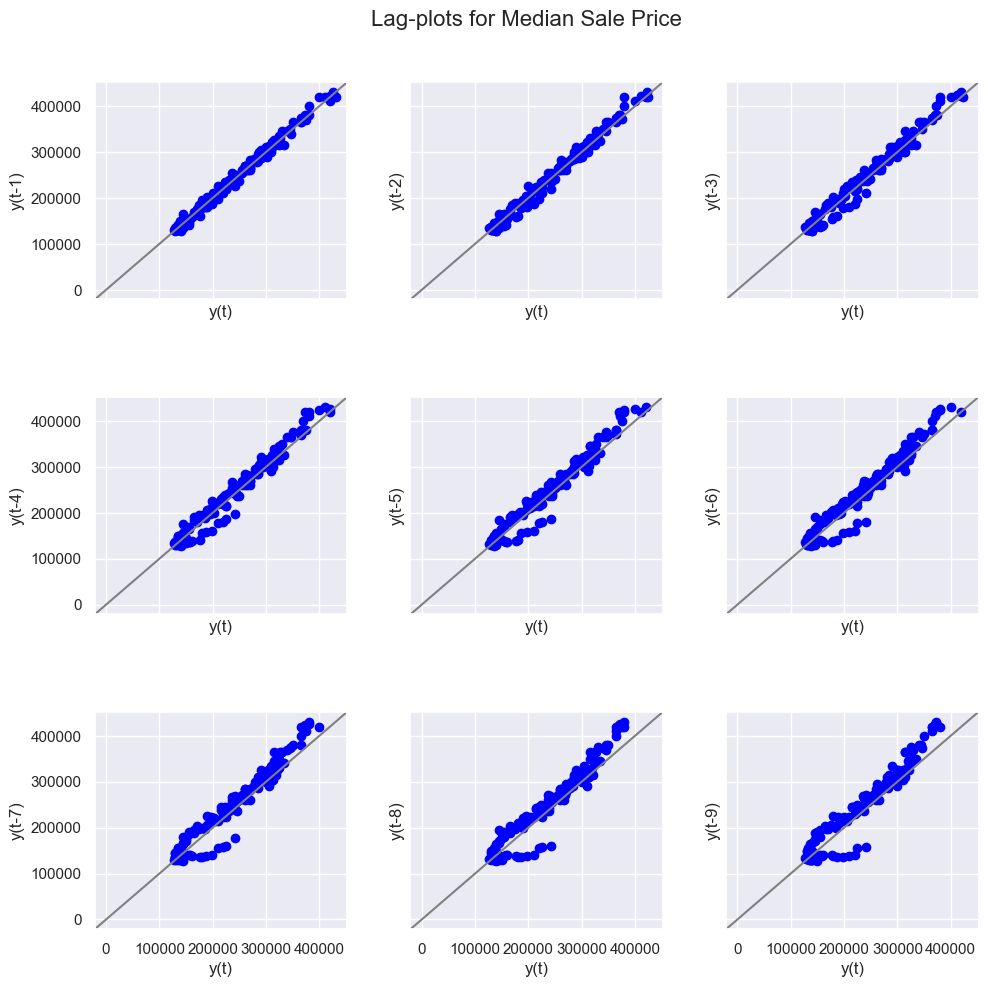

In [66]:
#create lag plots
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10, 10))
fig.suptitle("Lag-plots for Median Sale Price", fontsize=16)
plt.tight_layout(pad=2, h_pad=5)

for i, ax in enumerate(axes.flatten()[:9]):
    lag_plot(lagged_df['MedianSalesPrice'], lag=i+1, ax=ax, c='blue')
    ax.set_xlabel('y(t)')
    ax.set_ylabel(f'y(t-{i+1})')
    ax.axline((350, 350), slope=1, color='gray')

plt.show()

Lag plots shows that there is a clear pattern among all the lags, so data are not random. Data follows a trend that will be required to estimate.

### ACF

We now use Autocorrelation Plots to further explore the relation between observations with their past lags. Ideed, autocorrelation measures the linear relationship between lagged values of a time series. 

array([1.        , 0.98142026, 0.96267837, 0.94252043, 0.92168287,
       0.90115921, 0.88041178, 0.85841415, 0.83828977, 0.820812  ,
       0.80298499, 0.7856976 , 0.76814569, 0.74853784, 0.72968692,
       0.71012762, 0.69007272, 0.67276737, 0.65532068, 0.64010253,
       0.62235044])

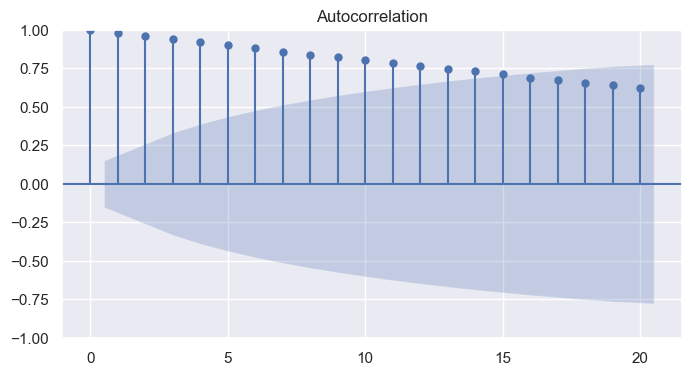

In [67]:
# Plot ACF and corresponding values
fig, ax = plt.subplots(figsize=(8,4))
plot_acf(median_sale_price_train_agg[['MedianSalesPrice']], lags=20,ax=ax);

val = acf(median_sale_price_train_agg[['MedianSalesPrice']],nlags=20)
display(val)

In [68]:
#FAI PLOT CON PACF !!!!!





The ACF slowly decrease menaning that we have a strong autocorrelation and a trend with a hige influence on our data.

### Frequency Analysis

Frequency analysis shows how the signal energy is distributed over a range of frequencies.

The Fourier Transform can be used for evaluating the frequency content of each signal and the caracteristics of each wave. It decomposes any signal into a sum of multiple sine/cosine signals of different frequencies.

### Power Spectral Density (PSD) based on Periodgram
PSD plots the power of each frequency component on the y-axis and the frequency on the x-axis. The power can be plotted in linear scale or in log scale. There are different ways to compute the PSD.

In this case i will use Periodogram. It represents the Fourier transform of the autocorrelation of the windowed data sequence.



This is out starting plot, we observe a clear incrasing trend. We now want explore whether there are or not seasonalities.

In [69]:
#the index ha no frequencey, we need to set before performing decomposition
print(median_sale_price_train_agg.index.freq)

None


In [70]:
#set the frequency for the index
median_sale_price_train_agg = median_sale_price_train_agg.asfreq('M')
median_sale_price_train_agg.index


DatetimeIndex(['2008-02-29', '2008-03-31', '2008-04-30', '2008-05-31',
               '2008-06-30', '2008-07-31', '2008-08-31', '2008-09-30',
               '2008-10-31', '2008-11-30',
               ...
               '2021-02-28', '2021-03-31', '2021-04-30', '2021-05-31',
               '2021-06-30', '2021-07-31', '2021-08-31', '2021-09-30',
               '2021-10-31', '2021-11-30'],
              dtype='datetime64[ns]', name='Date', length=166, freq='M')

,Freq,Period,Power
0,0.024096,41.500000,5.405353e+10
1,0.066265,15.090909,2.829514e+09
2,0.084337,11.857143,4.469878e+09
3,0.102410,9.764706,1.301481e+09


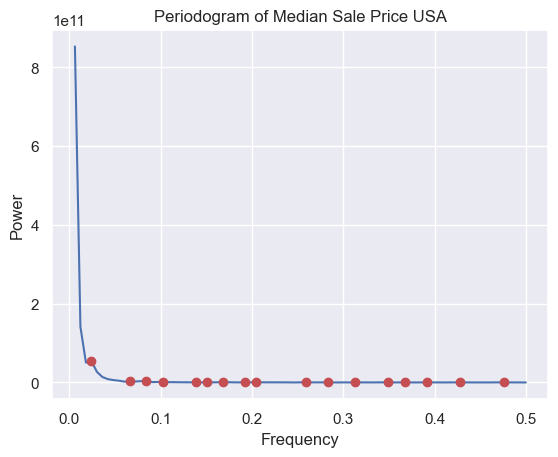

In [71]:
# Derive PSD using the periodogram and identify the periodicities in the data



signal_time=median_sale_price_train_agg['MedianSalesPrice']
Fs = 1 # 1 recording per month

f_per, Pxx_per = signal.periodogram(signal_time,Fs,detrend=None,window='boxcar',return_onesided=True,scaling='density')
plt.plot(f_per[1:],Pxx_per[1:])
plt.xlabel('Frequency [cycles/month]');

peaks = signal.find_peaks(Pxx_per[f_per >=0], prominence=max(Pxx_per)*0.00001)[0] 
peak_freq =  f_per[peaks]
peak_power = Pxx_per[peaks]
plt.plot(peak_freq, peak_power, 'ro')
plt.title('Periodogram of Median Sale Price USA')
plt.xlabel('Frequency')
plt.ylabel('Power')

data = {'Freq': peak_freq, 'Period': 1/peak_freq, 'Power': peak_power}
df = pd.DataFrame(data)[:4]
display(df)

The periodogram shows that no significant seasonalities are present in our data. This lead us to suspsect that the time series is mainly drive by trend component. The upcoming seasonal decomposition will clarify this aspect.

### Seasonal Decomposition

For seasonal decomposition we have opted for the additive model, since the amplitude of the signal do not increase over time.

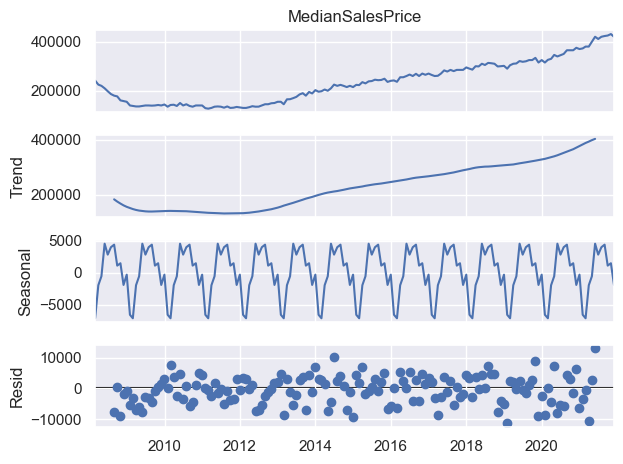

In [72]:
decompose_median_sale_price_train_agg = seasonal_decompose(median_sale_price_train_agg['MedianSalesPrice'], model='additive') #automatic period setting=12 
decompose_median_sale_price_train_agg.plot()
plt.show()

In seasonal decomposition we have not passed any period parameter (except for the default one). Looking at the trend and the residuals we do not notice any repeated pattern meaning. This means that there is no seasonality in our data, as previously shown with periodogram.

## Stationarity Tests

Before applying different models, it is crucial to verify whether or not our time series is stationary or not, meaning that mean and variance do not change over time.


The following plot shows that mean is not constant over time.

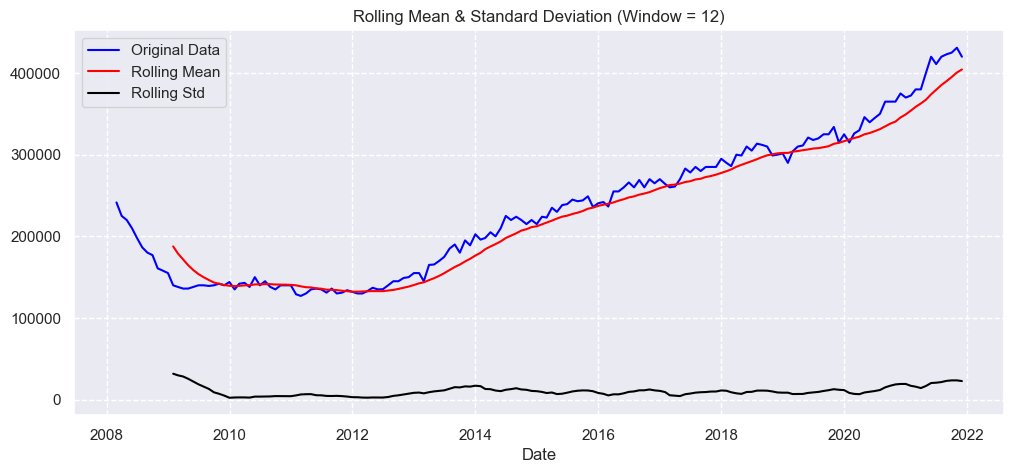

In [73]:

rolling_mean = median_sale_price_train_agg['MedianSalesPrice'].rolling(12).mean()
rolling_std = median_sale_price_train_agg['MedianSalesPrice'].rolling(12).std()

plt.figure(figsize=(12, 5))
plt.plot(median_sale_price_train_agg['MedianSalesPrice'], label='Original Data', color='blue')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std', color='black')

plt.legend(loc='best')
plt.title(f'Rolling Mean & Standard Deviation (Window = {12})')
plt.xlabel('Date')
plt.grid(True, linestyle='--')

plt.show()

### Stationary Tests

The orevious plot, together with Autocorrelation plot and seasonal decomposition, has already provide a relevant hint that our time series is not stationary because it is infleunced by a relevant trend.

We now use two tests in order to have a numerical check for stationarity, both of them must be positive in order to confirm stationarity:
* Augmented Dickey–Fuller test
* KPSS

In [74]:
def check_stationarity(series):
    """
     Performs the ADF and KPSS tests on the time series and returns a dataframe with the results.
    """
    # ADF Test
    adf_test = adfuller(series, autolag='AIC')
    adf_stat, adf_pvalue = adf_test[0], adf_test[1]
    adf_result = "Stationary" if adf_pvalue < 0.05 else "Not Stationary"

    # KPSS Test
    kpss_test = kpss(series, regression='c', nlags='auto')
    kpss_stat, kpss_pvalue = kpss_test[0], kpss_test[1]
    kpss_result = "Not Stationary" if kpss_pvalue < 0.05 else "Stationary"

    # Creazione DataFrame dei risultati
    results = pd.DataFrame({
        "ADF": [adf_stat],
        "P-value for ADF": [adf_pvalue],
        "ADF Stationarity": [adf_result],
        "KPSS": [kpss_stat],
        "P-value for KPSS": [kpss_pvalue],
        "KPSS Stationarity": [kpss_result]
    })

    return results

In [75]:
check_stationarity_median_sale_price_train_agg = check_stationarity(median_sale_price_train_agg['MedianSalesPrice'])
display(check_stationarity_median_sale_price_train_agg)

C:\Users\loren\AppData\Local\Temp\ipykernel_11340\3650091187.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(series, regression='c', nlags='auto')


,ADF,P-value for ADF,ADF Stationarity,KPSS,P-value for KPSS,KPSS Stationarity
0,2.394895,0.999008,Not Stationary,1.761261,0.01,Not Stationary


### Obtain Stationarity

In order to achieve stationarity we perfrom first order differencing.

In [76]:
#compute fiest order differencing as percental change wrt previous observation
median_sale_price_train_diff_1 = median_sale_price_train_agg['MedianSalesPrice'].pct_change().mul(100)

#drop first nan value
median_sale_price_train_diff_1.dropna(inplace=True)


#apply stationary test
check_stationarity_median_sale_price_train_diff_1 = check_stationarity(median_sale_price_train_diff_1)
display(check_stationarity_median_sale_price_train_diff_1)

,ADF,P-value for ADF,ADF Stationarity,KPSS,P-value for KPSS,KPSS Stationarity
0,-15.774584,1.150249e-28,Stationary,0.704182,0.013165,Not Stationary


First order differencing is not enought to obtain stationarity.

We perform second order differencing.

In [ ]:
# Computa la differenziazione di secondo ordine come variazione percentuale
median_sale_price_train_diff_2 = median_sale_price_train_diff_1.pct_change().mul(100)

# Rimuove eventuali valori NaN o Inf
median_sale_price_train_diff_2 = median_sale_price_train_diff_2.replace([np.inf, -np.inf], np.nan).dropna()

# Applica il test di stazionarietà
check_stationarity_median_sale_price_train_diff_2 = check_stationarity(median_sale_price_train_diff_2)

# Mostra i risultati
display(check_stationarity_median_sale_price_train_diff_2)


C:\Users\loren\AppData\Local\Temp\ipykernel_11340\3650091187.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(series, regression='c', nlags='auto')


,ADF,P-value for ADF,ADF Stationarity,KPSS,P-value for KPSS,KPSS Stationarity
0,-11.478889,5.051265e-21,Stationary,0.150532,0.1,Stationary


With second order differentiation we succeed in achieving stationarity.

## Time Series Pattern Analysis

We now focus on the analysis on specific US states. In order to choose what are the most appropriate states to consider we consider two parameters:
* number of observations
* % of missing values

In [81]:
#states with most observations

state_counts = median_sale_price_train.groupby("StateName")["RegionID"].count().reset_index()
state_counts = state_counts.sort_values(by="RegionID", ascending=False)  # Ordina in ordine decrescente
state_counts.columns = ["StateName", "Observations"]
display(state_counts.head(10))


#states with lower % of missing observation
missing_median_sale_df.tail(40)[1:-1]

,StateName,Observations
33,OH,6972
25,NC,5644
41,TX,5644
20,MI,5146
36,PA,5146
13,IN,5146
3,CA,4980
7,FL,4482
32,NY,4150
12,IL,3984


,Missing Count,Missing %
StateName,,
MO,1284.0,31.94
KY,986.0,30.66
OH,2578.0,30.54
IA,887.0,29.42
OK,827.0,27.43
IL,1185.0,24.56
UT,440.0,24.32
TX,1513.0,22.14
MI,1356.0,21.76


Given the above data, the selected states to perform further analysis are:

* CA: California
* FL: Florida
* IL: Illinois
* MI: MIchigan
* NC: North Carolina

In [92]:
#create the df for the selected US states:

#CALIFORNIA
median_sale_price_train_CA=median_sale_price_train[median_sale_price_train['StateName']=='CA']
median_sale_price_train_CA= median_sale_price_train_CA[['MedianSalesPrice']].groupby(median_sale_price_train_CA.index).mean()

#FLORIDA
median_sale_price_train_FL=median_sale_price_train[median_sale_price_train['StateName']=='FL']
median_sale_price_train_FL= median_sale_price_train_FL[['MedianSalesPrice']].groupby(median_sale_price_train_FL.index).mean()


#ILLINOIS
median_sale_price_train_IL=median_sale_price_train[median_sale_price_train['StateName']=='IL']
median_sale_price_train_IL= median_sale_price_train_IL[['MedianSalesPrice']].groupby(median_sale_price_train_IL.index).mean()

#MICHIGAN
median_sale_price_train_MI=median_sale_price_train[median_sale_price_train['StateName']=='MI']
median_sale_price_train_MI= median_sale_price_train_MI[['MedianSalesPrice']].groupby(median_sale_price_train_MI.index).mean()

#NORTH CAOLINA
median_sale_price_train_NC=median_sale_price_train[median_sale_price_train['StateName']=='NC']
median_sale_price_train_NC= median_sale_price_train_NC[['MedianSalesPrice']].groupby(median_sale_price_train_NC.index).mean()




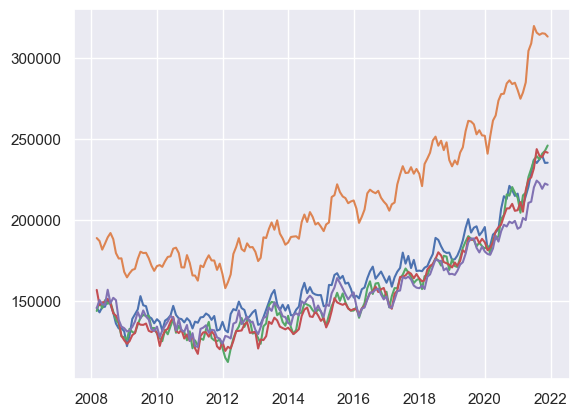

In [97]:
plt.plot(median_sale_price_train_CA)
plt.plot(median_sale_price_train_FL)
plt.plot(median_sale_price_train_IL)
plt.plot(median_sale_price_train_MI)
plt.plot(median_sale_price_train_NC)






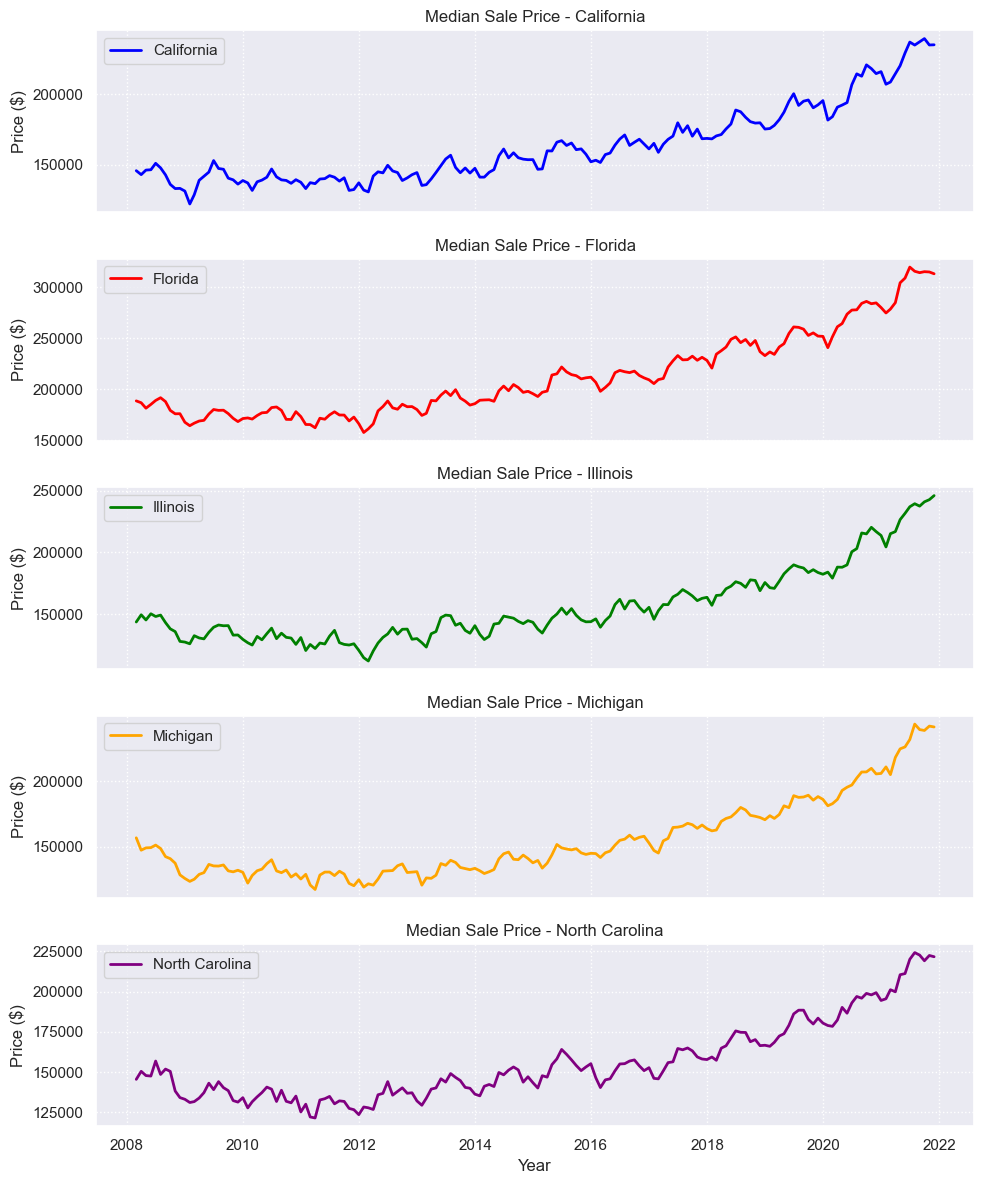

In [98]:

# Creazione della figura con 5 subplot (uno per stato)
fig, axes = plt.subplots(5, 1, figsize=(10, 12), sharex=True)

# Plottiamo ogni stato in un subplot diverso
states_train_data = {
    'California': median_sale_price_train_CA,
    'Florida': median_sale_price_train_FL,
    'Illinois': median_sale_price_train_IL,
    'Michigan': median_sale_price_train_MI,
    'North Carolina': median_sale_price_train_NC
}

colors = ['blue', 'red', 'green', 'orange', 'purple']

for ax, (state, data), color in zip(axes, states_train_data.items(), colors):
    ax.plot(data.index, data['MedianSalesPrice'], label=state, color=color, linewidth=2)
    ax.set_title(f'Median Sale Price - {state}')
    ax.set_ylabel('Price ($)')
    ax.legend()
    ax.grid(True, linestyle=':')

# Impostiamo l'asse X nell'ultimo subplot
axes[-1].set_xlabel('Year')

plt.tight_layout()
plt.show()


### Lag Plots

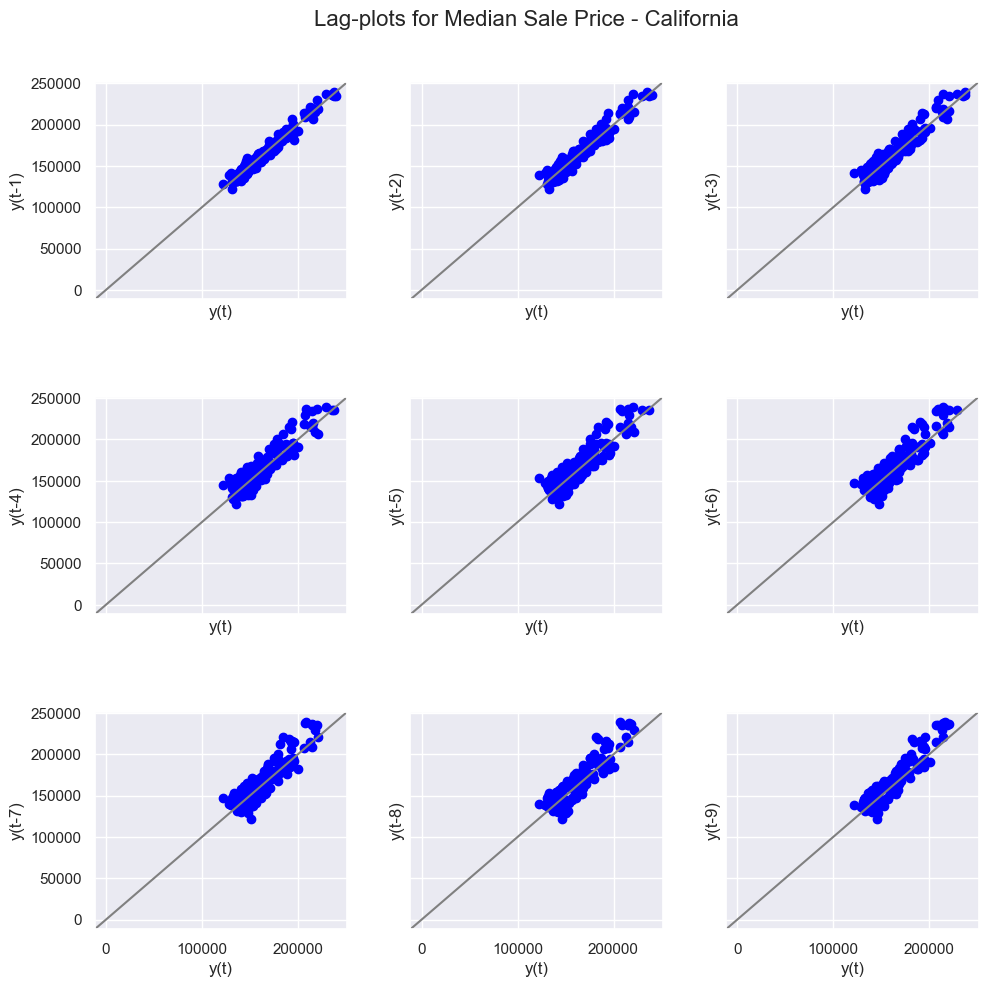

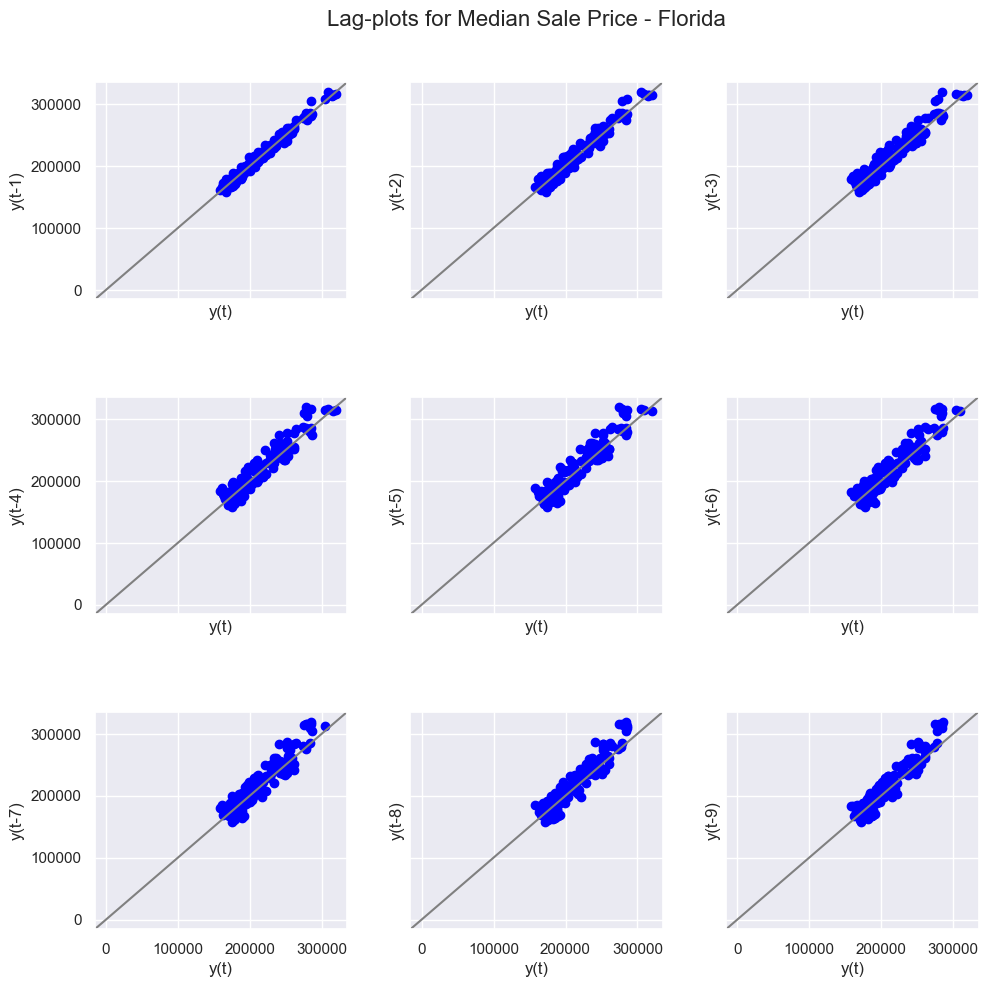

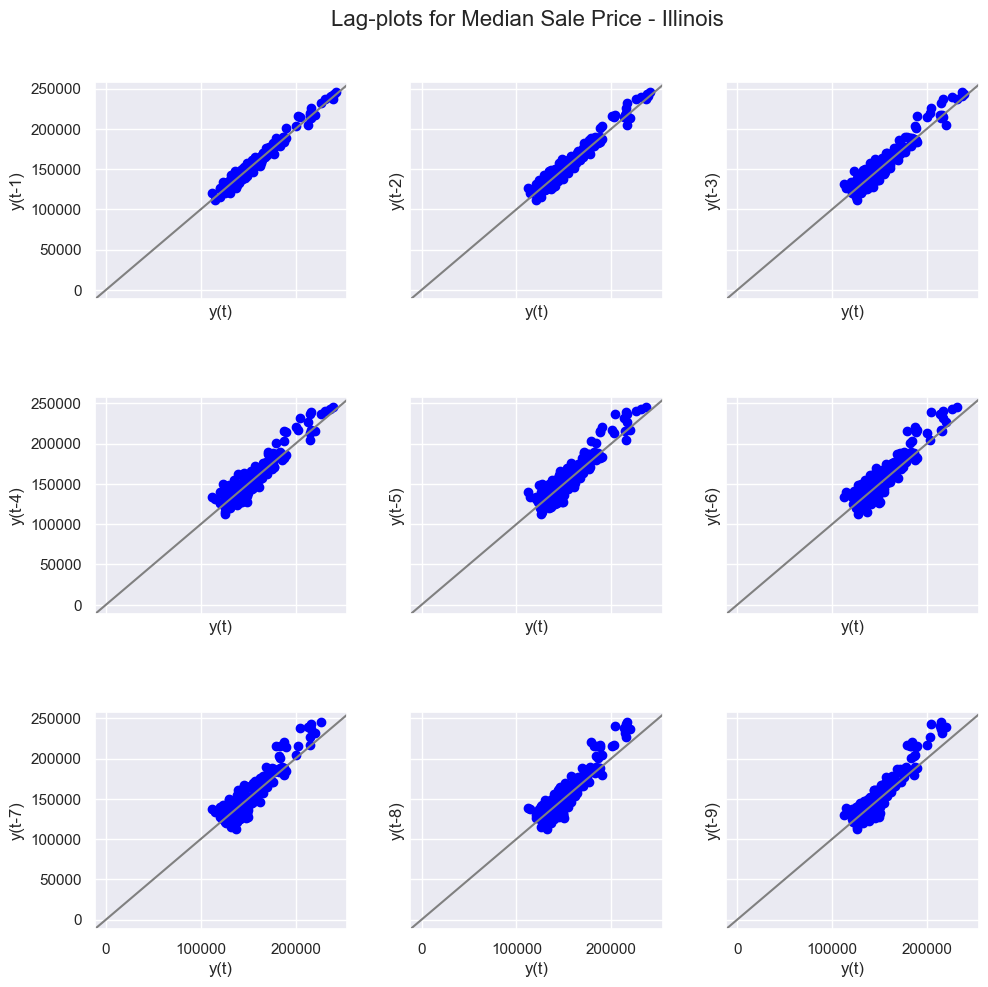

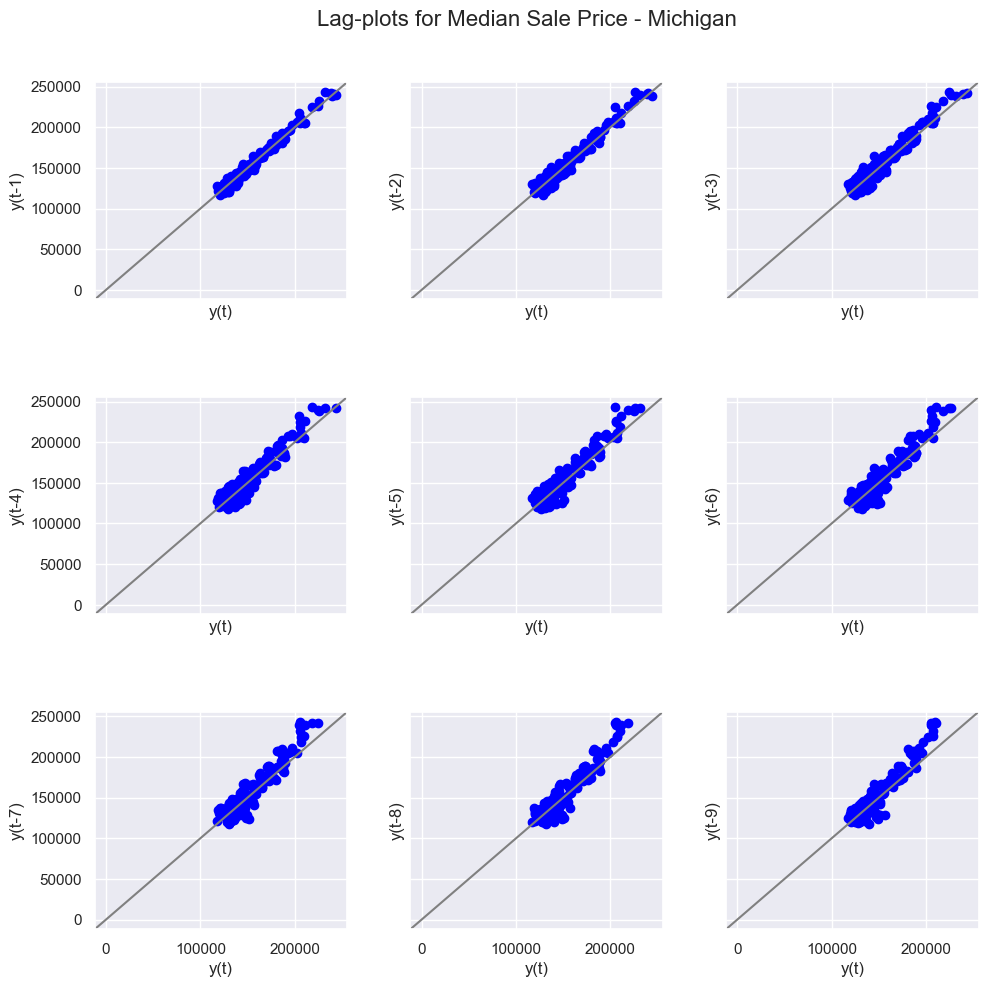

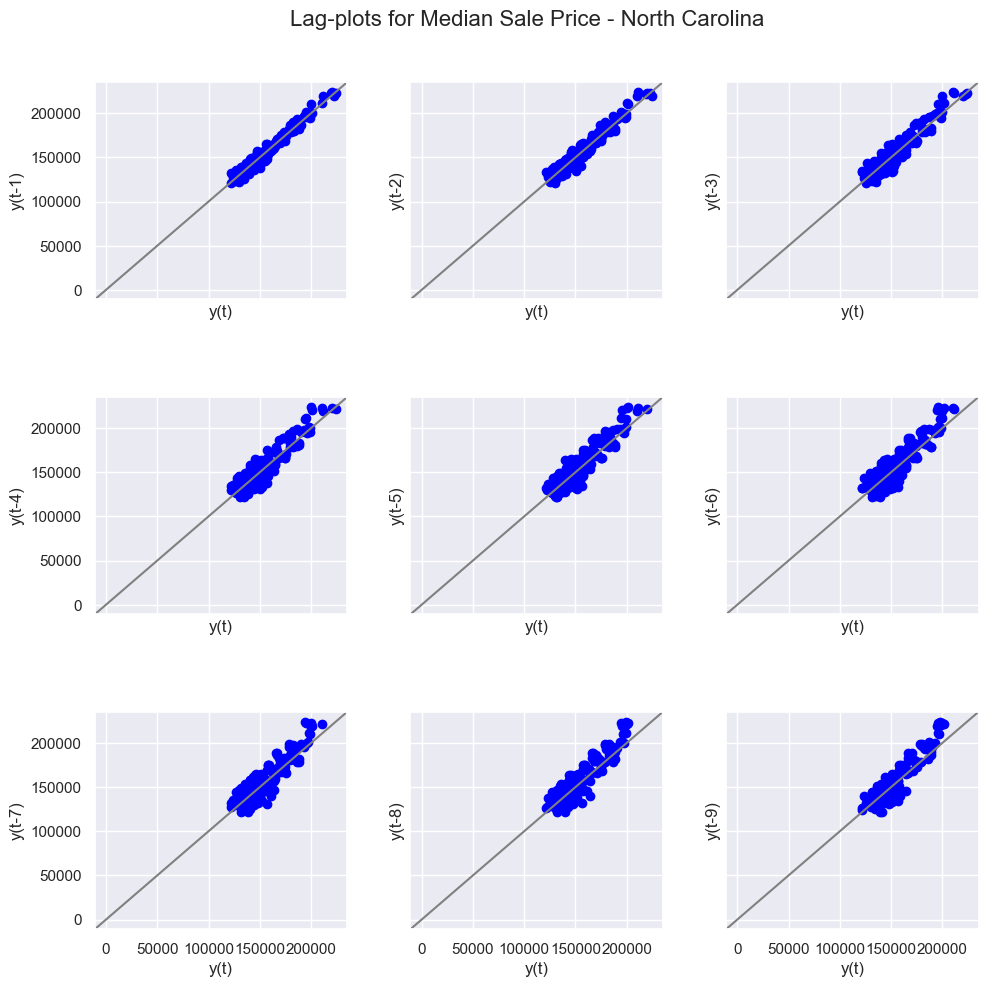

In [100]:
# Creare i lag plots per ogni stato nel dizionario states_train_data
for state, df in states_train_data.items():
    fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10, 10))
    fig.suptitle(f"Lag-plots for Median Sale Price - {state}", fontsize=16)
    plt.tight_layout(pad=2, h_pad=5)

    for i, ax in enumerate(axes.flatten()[:9]):  # Creiamo 9 lag plot per ogni stato
        lag_plot(df['MedianSalesPrice'], lag=i+1, ax=ax, c='blue')
        ax.set_xlabel(f"y(t)")
        ax.set_ylabel(f"y(t-{i+1})")
        ax.axline((350, 350), slope=1, color='gray')

    plt.show()



### ACF

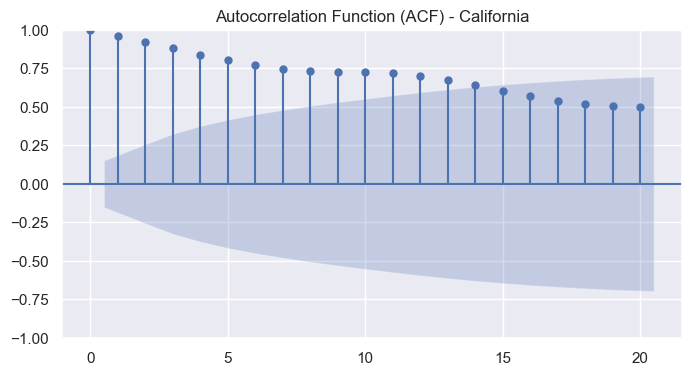

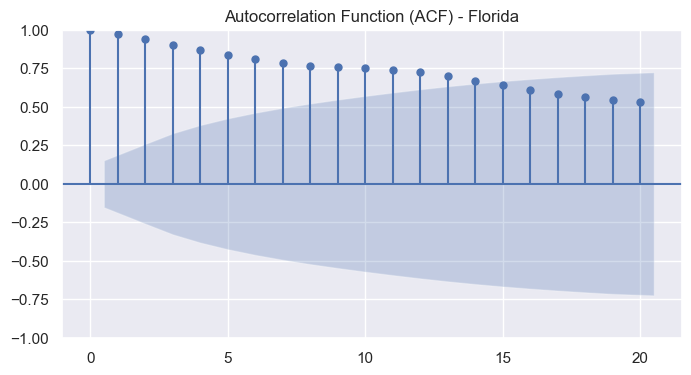

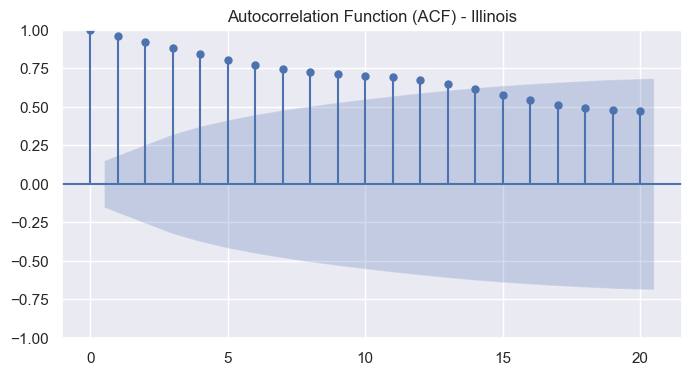

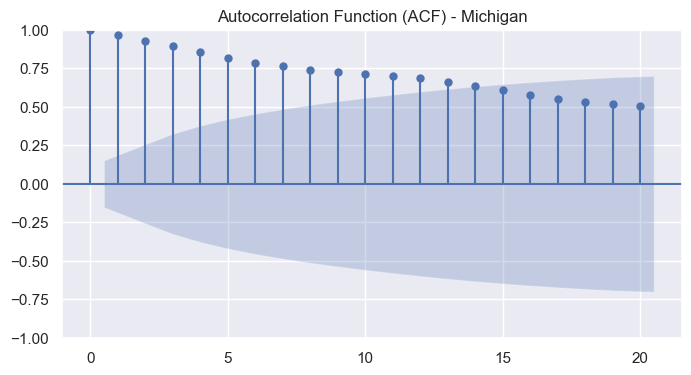

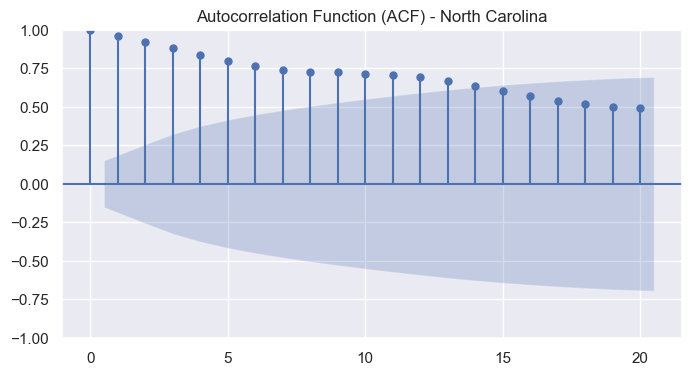

In [101]:
for state, df in states_train_data.items():
    fig, ax = plt.subplots(figsize=(8, 4))
    plot_acf(df[['MedianSalesPrice']], lags=20, ax=ax)
    ax.set_title(f"Autocorrelation Function (ACF) - {state}")
    
    # Calcolare i valori di ACF
    val = acf(df[['MedianSalesPrice']], nlags=20)
    
    plt.show()

### Frequency Analysis

In [108]:
#set month frequency to all countries
for state, df in states_train_data.items():
    states_train_data[state] = df.asfreq('M')

for state, df in states_train_data.items():
    print(f"Frequency of data for{state}: {df.index.freq}")



Frequency of data forCalifornia: <MonthEnd>
Frequency of data forFlorida: <MonthEnd>
Frequency of data forIllinois: <MonthEnd>
Frequency of data forMichigan: <MonthEnd>
Frequency of data forNorth Carolina: <MonthEnd>


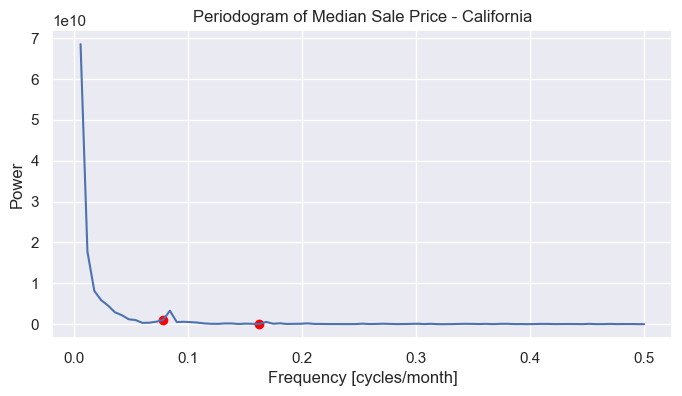

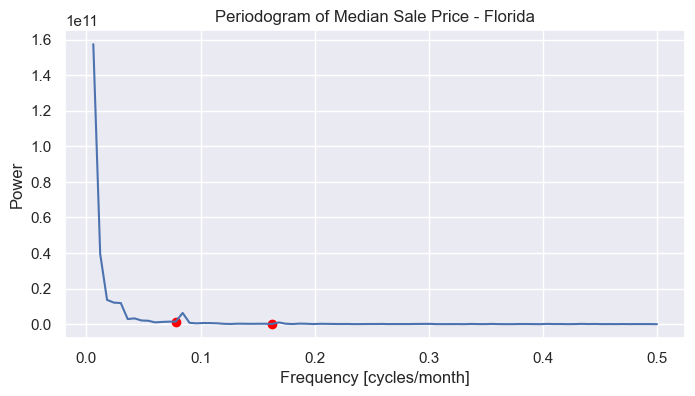

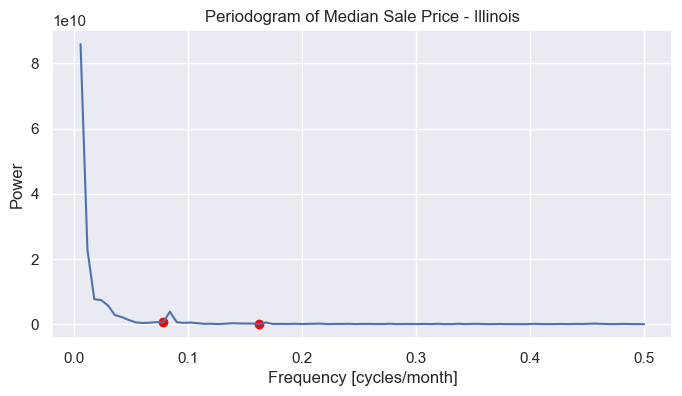

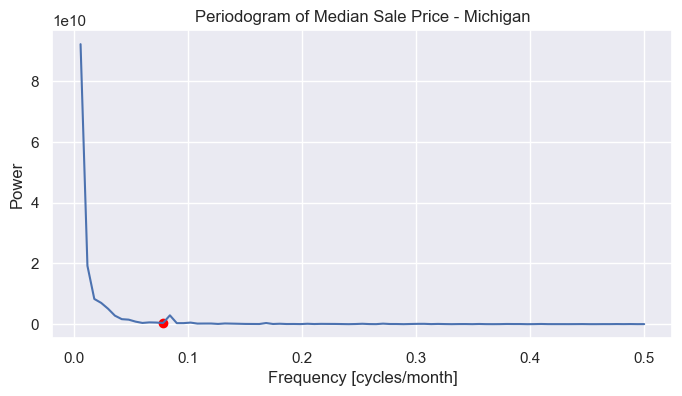

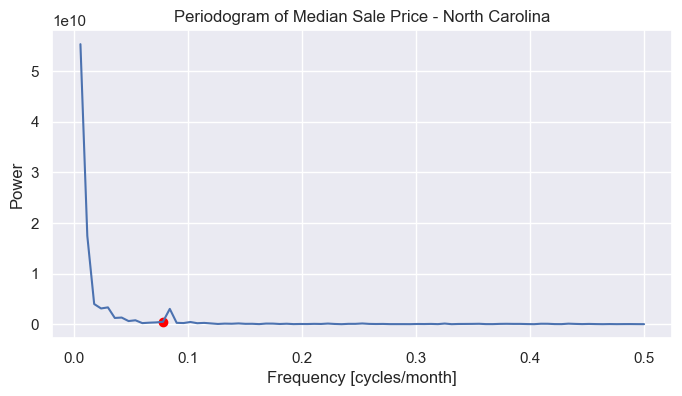

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import periodogram, find_peaks

# Calcolare il periodogramma per ogni stato
for state, df in states_train_data.items():
    signal_time = df['MedianSalesPrice']
    Fs = 1  # 1 registrazione per mese

    # Calcolare il periodogramma
    f_per, Pxx_per = periodogram(signal_time, fs=Fs, detrend=None, window='boxcar', return_onesided=True, scaling='density')

    # Trovare i picchi significativi
    peaks, _ = find_peaks(Pxx_per[f_per > 0], prominence=max(Pxx_per) * 0.0001)
    peak_freq = f_per[peaks]
    peak_power = Pxx_per[peaks]

    # Creare il DataFrame con i risultati
    data = {'Freq': peak_freq, 'Period': 1 / peak_freq, 'Power': peak_power}
    df_period = pd.DataFrame(data)


    # Plot del periodogramma
    plt.figure(figsize=(8, 4))
    plt.plot(f_per[1:], Pxx_per[1:])
    plt.scatter(peak_freq, peak_power, color='red', marker='o')  # Evidenziare i picchi
    plt.xlabel("Frequency [cycles/month]")
    plt.ylabel("Power")
    plt.title(f"Periodogram of Median Sale Price - {state}")
    plt.show()


### Seasonal Decomposition

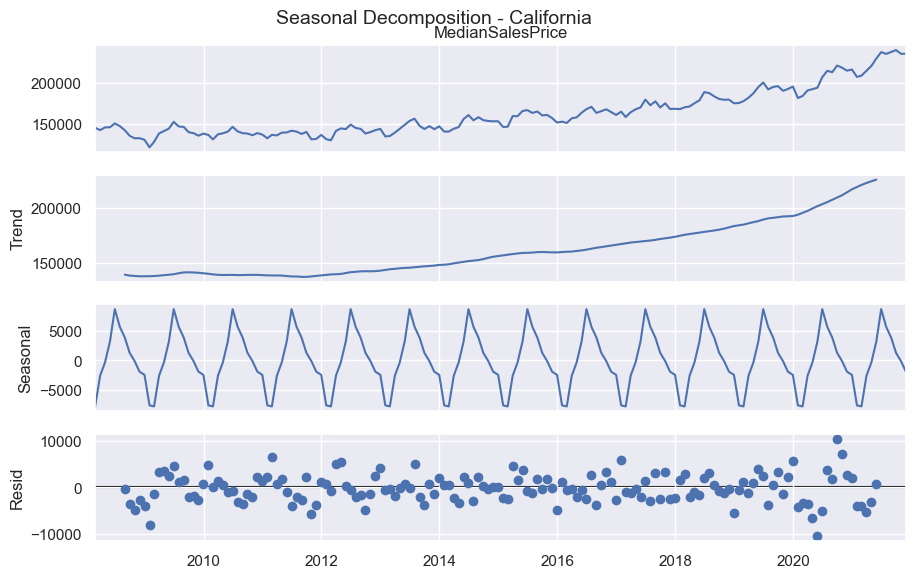

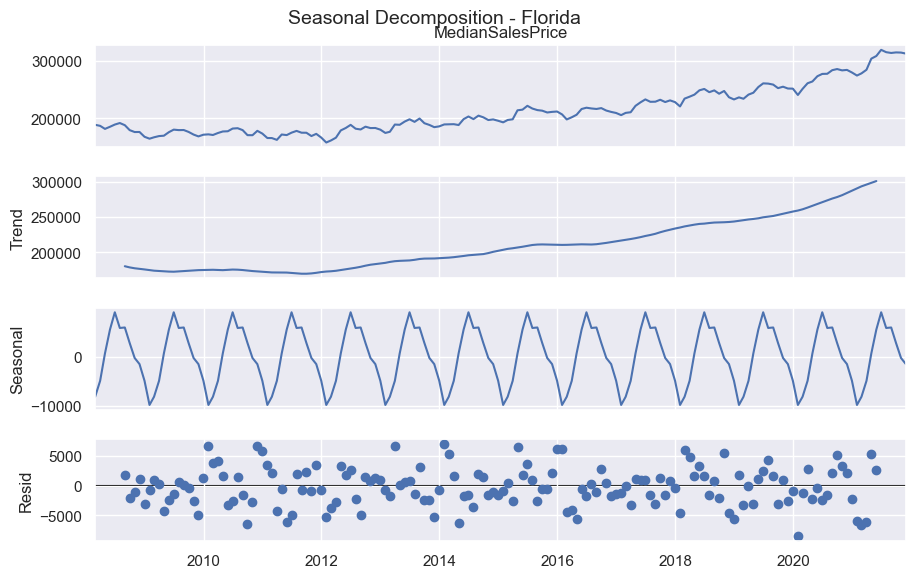

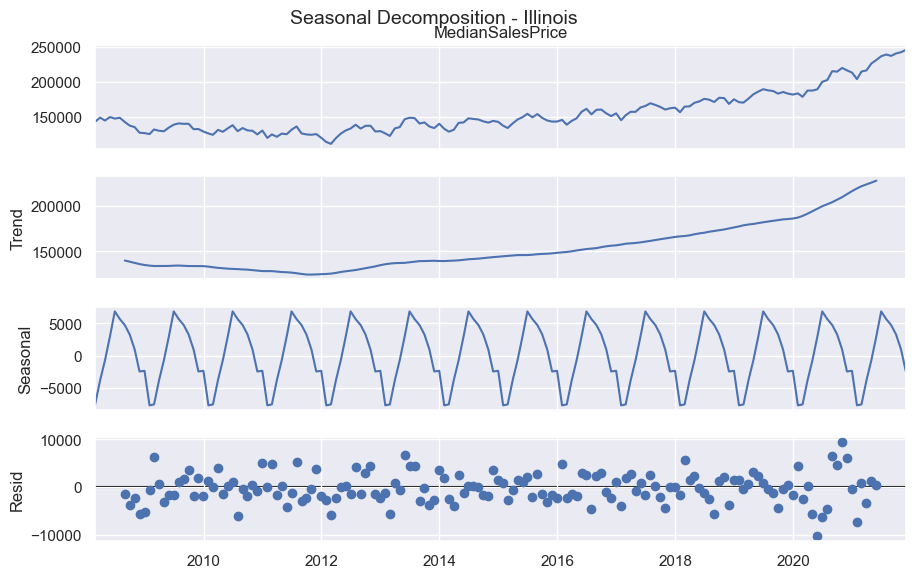

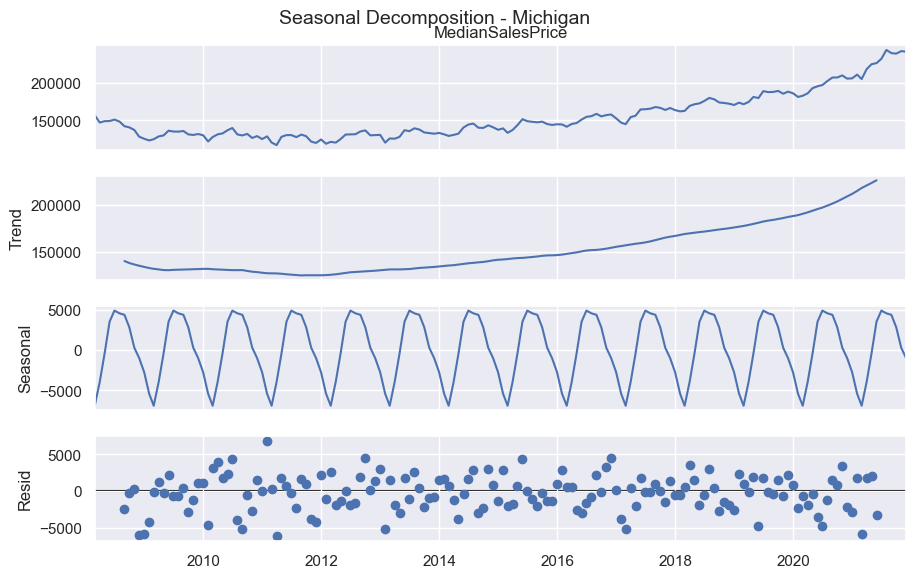

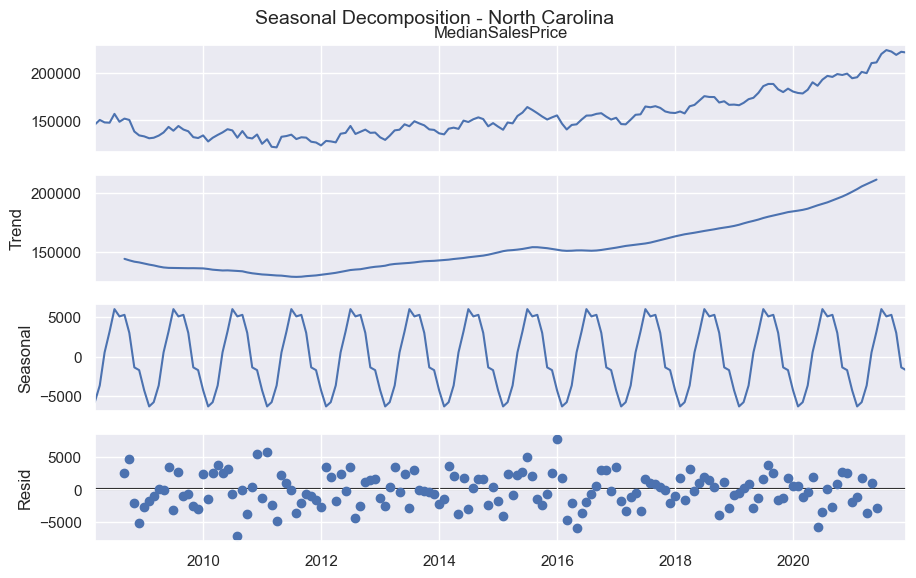

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Eseguire la decomposizione stagionale per ogni stato
for state, df in states_train_data.items():
    # Eseguire la decomposizione stagionale
    decomposition = seasonal_decompose(df['MedianSalesPrice'], model='additive', period=12)  
    
    # Plot della decomposizione
    fig = decomposition.plot()
    fig.set_size_inches(10, 6)
    plt.suptitle(f"Seasonal Decomposition - {state}", fontsize=14)
    plt.show()


### Stationarity

#### Stationarity Tests

In [132]:
for state, df in states_train_data.items():
    stationarity_results[state] = check_stationarity(df['MedianSalesPrice'])
    
    # Stampare i risultati
    print(f"Stationarity Test - {state}")
    display(stationarity_results[state])

Stationarity Test - California


C:\Users\loren\AppData\Local\Temp\ipykernel_11340\3650091187.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(series, regression='c', nlags='auto')


,ADF,P-value for ADF,ADF Stationarity,KPSS,P-value for KPSS,KPSS Stationarity
0,3.708015,1.0,Not Stationary,1.698302,0.01,Not Stationary


Stationarity Test - Florida


C:\Users\loren\AppData\Local\Temp\ipykernel_11340\3650091187.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(series, regression='c', nlags='auto')


,ADF,P-value for ADF,ADF Stationarity,KPSS,P-value for KPSS,KPSS Stationarity
0,2.494048,0.999048,Not Stationary,1.740973,0.01,Not Stationary


Stationarity Test - Illinois


C:\Users\loren\AppData\Local\Temp\ipykernel_11340\3650091187.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(series, regression='c', nlags='auto')


,ADF,P-value for ADF,ADF Stationarity,KPSS,P-value for KPSS,KPSS Stationarity
0,5.356788,1.0,Not Stationary,1.573081,0.01,Not Stationary


Stationarity Test - Michigan


C:\Users\loren\AppData\Local\Temp\ipykernel_11340\3650091187.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(series, regression='c', nlags='auto')


,ADF,P-value for ADF,ADF Stationarity,KPSS,P-value for KPSS,KPSS Stationarity
0,3.566591,1.0,Not Stationary,1.573181,0.01,Not Stationary


Stationarity Test - North Carolina


C:\Users\loren\AppData\Local\Temp\ipykernel_11340\3650091187.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(series, regression='c', nlags='auto')


,ADF,P-value for ADF,ADF Stationarity,KPSS,P-value for KPSS,KPSS Stationarity
0,2.601286,0.999075,Not Stationary,1.589502,0.01,Not Stationary


#### Obtain Stationarity

In [142]:
# Creare un dizionario per salvare le serie con doppia differenziazione
second_order_diff = {}
stationarity_results_diff = {}

# Applicare la differenziazione di secondo ordine e test di stazionarietà per ogni stato
for state, df in states_train_data.items():
    # Primo differenziamento
    diff_1 = df['MedianSalesPrice'].pct_change().mul(100)
    
    # Secondo differenziamento
    diff_2 = diff_1.pct_change().mul(100)
    
    # Rimuovere eventuali NaN o Inf
    diff_2 = diff_2.replace([np.inf, -np.inf], np.nan).dropna()

    # Salvare la serie differenziata
    second_order_diff[state] = diff_2
    
    # Applicare il test di stazionarietà
    stationarity_results_diff[state] = check_stationarity(diff_2)

# Mostrare i risultati dei test di stazionarietà dopo la differenziazione di secondo ordine
for state, result in stationarity_results_diff.items():
    print(f"Stationarity Test after 2nd Order Differencing - {state}")
    display(result)


Stationarity Test after 2nd Order Differencing - California


C:\Users\loren\AppData\Local\Temp\ipykernel_11340\3650091187.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(series, regression='c', nlags='auto')
C:\Users\loren\AppData\Local\Temp\ipykernel_11340\3650091187.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(series, regression='c', nlags='auto')
C:\Users\loren\AppData\Local\Temp\ipykernel_11340\3650091187.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(series, regression='c', nlags='auto')
C:\Users\loren\AppData\Local\Temp\ipykernel_11340\3650091187.py:11: InterpolationWarning: The test statistic is outside of t

,ADF,P-value for ADF,ADF Stationarity,KPSS,P-value for KPSS,KPSS Stationarity
0,-12.748267,8.645299e-24,Stationary,0.079209,0.1,Stationary


Stationarity Test after 2nd Order Differencing - Florida


,ADF,P-value for ADF,ADF Stationarity,KPSS,P-value for KPSS,KPSS Stationarity
0,-4.735821,0.000072,Stationary,0.187437,0.1,Stationary


Stationarity Test after 2nd Order Differencing - Illinois


,ADF,P-value for ADF,ADF Stationarity,KPSS,P-value for KPSS,KPSS Stationarity
0,-13.108435,1.653879e-24,Stationary,0.198858,0.1,Stationary


Stationarity Test after 2nd Order Differencing - Michigan


,ADF,P-value for ADF,ADF Stationarity,KPSS,P-value for KPSS,KPSS Stationarity
0,-12.646551,1.397676e-23,Stationary,0.361936,0.093562,Stationary


Stationarity Test after 2nd Order Differencing - North Carolina


,ADF,P-value for ADF,ADF Stationarity,KPSS,P-value for KPSS,KPSS Stationarity
0,-12.76828,7.870906e-24,Stationary,0.195267,0.1,Stationary
